<a href="https://colab.research.google.com/github/eagning1/DE1-G29/blob/main/DE1_G29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install nltk

In [2]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC  # Use LinearSVC instead of SVC for memory efficiency
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from collections import Counter, defaultdict
import random
from timeit import default_timer as timer
import re
import warnings
from wordcloud import WordCloud
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction import DictVectorizer
warnings.filterwarnings('ignore')

In [4]:
# Download VADER lexicon if not already downloaded
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\erkoo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
# Set the style for our plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)

In [6]:
class LyricsAnalyzer:
    def __init__(self, matches_file, train_file, sample_size=None):
        """
        Initialize the LyricsAnalyzer with the paths to the dataset files.
        
        Parameters:
        -----------
        matches_file : str
            Path to the mxm_779k_matches.txt file
        train_file : str
            Path to the mxm_dataset_train.txt file
        sample_size : int, optional
            If provided, only load a random sample of this many songs
        """
        self.matches_file = matches_file
        self.train_file = train_file
        self.sample_size = sample_size
        self.top_words = []
        self.matches_df = None
        self.lyrics_df = None
        self.word_counts = None
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        
    def load_matches(self):
        """Load and parse the matches file"""
        print("Loading matches data...")
        # Define column names based on the file format
        columns = ['msd_track_id', 'msd_artist_name', 'msd_title', 'mxm_track_id', 'mxm_artist_name', 'mxm_title']
        
        # Read the file
        data = []
        with open(self.matches_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):  # Skip comment lines
                    continue
                parts = line.strip().split('<SEP>')
                if len(parts) == 6:  # Ensure we have all fields
                    data.append(parts)
        
        # Create DataFrame
        self.matches_df = pd.DataFrame(data, columns=columns)
        print(f"Loaded {len(self.matches_df)} song matches.")
        return self.matches_df
    
    def load_lyrics(self, track_ids=None):
        """
        Load and parse the lyrics training file
        
        Parameters:
        -----------
        track_ids : list, optional
            If provided, only load lyrics for these track IDs
        """
        print("Loading lyrics data...")
        # First, extract the top words list
        self.top_words = []
        word_counts_data = []
        
        # If sample_size is set but no track_ids provided, get a list of all track_ids first
        if self.sample_size is not None and track_ids is None:
            print(f"Getting track IDs for sampling {self.sample_size} songs...")
            all_track_ids = []
            with open(self.train_file, 'r', encoding='utf-8') as f:
                for line in f:
                    if line.startswith('#') or line.startswith('%'):
                        continue
                    parts = line.strip().split(',')
                    if len(parts) >= 1:
                        all_track_ids.append(parts[0])
            
            # Randomly sample track_ids
            sampled_track_ids = set(random.sample(all_track_ids, min(self.sample_size, len(all_track_ids))))
            print(f"Sampled {len(sampled_track_ids)} tracks")
            track_ids = sampled_track_ids
        
        # Now read the file
        with open(self.train_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):  # Skip comment lines
                    continue
                elif line.startswith('%'):  # Extract top words
                    self.top_words = line[1:].strip().split(',')
                else:
                    # Parse the word count line
                    parts = line.strip().split(',')
                    if len(parts) >= 2:
                        track_id = parts[0]
                        
                        # Skip if not in the track_ids list
                        if track_ids is not None and track_id not in track_ids:
                            continue
                            
                        mxm_track_id = parts[1]
                        
                        # Create a sparse word count dictionary
                        word_counts = {}
                        for item in parts[2:]:
                            if ':' in item:
                                idx, count = item.split(':')
                                # Convert to 0-based index and ensure it's within range
                                word_idx = int(idx) - 1  # 1-based to 0-based
                                if word_idx < len(self.top_words):
                                    word_counts[self.top_words[word_idx]] = int(count)
                        
                        word_counts_data.append({
                            'track_id': track_id,
                            'mxm_track_id': mxm_track_id,
                            'word_counts': word_counts
                        })
        
        # Create DataFrame
        self.lyrics_df = pd.DataFrame(word_counts_data)
        print(f"Loaded lyrics data for {len(self.lyrics_df)} songs with {len(self.top_words)} vocabulary words.")
        return self.lyrics_df
    
    def merge_data(self):
        """Merge the matches and lyrics data"""
        if self.matches_df is None:
            self.load_matches()
        if self.lyrics_df is None:
            self.load_lyrics()
        
        # Merge on mxm_track_id
        merged_df = pd.merge(
            self.lyrics_df,
            self.matches_df,
            left_on='mxm_track_id',
            right_on='mxm_track_id',
            how='inner'
        )
        
        print(f"Merged data contains {len(merged_df)} songs.")
        return merged_df
    
    def create_word_count_matrix(self):
        """Convert sparse word counts to a matrix format"""
        if self.lyrics_df is None:
            self.load_lyrics()
        
        # Create a matrix where rows are songs and columns are words
        word_count_matrix = np.zeros((len(self.lyrics_df), len(self.top_words)))
        
        for i, row in enumerate(self.lyrics_df['word_counts']):
            for word, count in row.items():
                if word in self.top_words:
                    col_idx = self.top_words.index(word)
                    word_count_matrix[i, col_idx] = count
        
        self.word_counts = pd.DataFrame(word_count_matrix, columns=self.top_words)
        return self.word_counts
    
    def calculate_sentiment(self, merged_data=None):
        """Calculate sentiment scores for each song based on its word counts"""
        if merged_data is None:
            merged_data = self.merge_data()
        
        sentiment_scores = []
        
        for _, row in merged_data.iterrows():
            word_counts = row['word_counts']
            
            # Convert word counts to a pseudo-text for VADER
            # Repeat each word by its count to give it proper weight
            pseudo_text = ' '.join([f"{word} " * count for word, count in word_counts.items()])
            
            # Get sentiment scores
            sentiment = self.sentiment_analyzer.polarity_scores(pseudo_text)
            sentiment_scores.append({
                'track_id': row['track_id'],
                'artist': row['msd_artist_name'],
                'title': row['msd_title'],
                'negative': sentiment['neg'],
                'neutral': sentiment['neu'],
                'positive': sentiment['pos'],
                'compound': sentiment['compound']
            })
        
        sentiment_df = pd.DataFrame(sentiment_scores)
        return sentiment_df

    def load_genre_data(self, genre_file):
        """Load genre assignments for tracks"""
        print("Loading genre data...")
        genre_data = {}
        
        with open(genre_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):  # Skip comment lines
                    continue
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    track_id, genre = parts
                    genre_data[track_id] = genre
        
        print(f"Loaded genre data for {len(genre_data)} songs.")
        return genre_data
    
    def merge_genre_data(self, genre_data, merged_data=None):
        """Add genre information to the merged dataset"""
        if merged_data is None:
            merged_data = self.merge_data()
        
        # Create a new column for genre
        merged_data['genre'] = merged_data['track_id'].map(genre_data)
        
        # Filter out tracks without genre information
        merged_data_with_genre = merged_data.dropna(subset=['genre'])
        print(f"Merged data contains {len(merged_data_with_genre)} songs with genre information.")
        
        # Filter genres with at least 2 songs (needed for train/test split)
        genre_counts = merged_data_with_genre['genre'].value_counts()
        valid_genres = genre_counts[genre_counts >= 2].index
        merged_data_with_genre = merged_data_with_genre[merged_data_with_genre['genre'].isin(valid_genres)]
        print(f"After filtering for genres with at least 2 songs: {len(merged_data_with_genre)} songs remaining.")
        
        return merged_data_with_genre
    
    def prepare_features_for_classification(self, data=None, remove_words=None, target_genres=None):
        """
        Prepare features for genre classification, optionally removing specific words
        and mapping non-target genres to 'Other'
        
        Parameters:
        -----------
        data : DataFrame, optional
            The dataframe containing the data
        remove_words : list, optional
            List of words to remove from the features
        target_genres : list, optional
            List of genres to keep as separate classes, all others will be mapped to 'Other'
        
        Returns:
        --------
        X : sparse matrix
            Feature matrix
        vectorizer : DictVectorizer
            Fitted vectorizer
        """
        if data is None:
            data = self.merge_data()
            
        if remove_words is None:
            remove_words = ['i', 'the', 'a', 'to', 'you', 'and', 'me']
        
        # Create features from word counts
        features = []
        
        for _, row in data.iterrows():
            word_counts = row['word_counts']
            # Remove specified words
            filtered_counts = {word: count for word, count in word_counts.items() 
                             if word not in remove_words}
            features.append(filtered_counts)
        
        # Convert to matrix format
        
        vectorizer = DictVectorizer(sparse=True)
        X = vectorizer.fit_transform(features)
        
        # If target genres are specified, transform the genre labels
        if target_genres is not None and 'genre' in data.columns:
            data['original_genre'] = data['genre']
            data['genre'] = data['genre'].apply(lambda x: x if x in target_genres else 'Other')
        
        return X, vectorizer
    
    def train_genre_classifier(self, X_train, y_train, use_linear=True):
        """
        Train an SVM classifier for genre prediction
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        y_train : array-like
            Training labels
        use_linear : bool, default=True
            If True, use LinearSVC (memory efficient), else use SVC with linear kernel
        """
        
        
        # Create a pipeline with scaling and SVM
        if use_linear:
            # Use LinearSVC for better memory efficiency

            pipeline = Pipeline([
                ('scaler', StandardScaler(with_mean=False)),  # Don't subtract mean for sparse data
                ('svm', LinearSVC(dual=False, C=1.0, random_state=42, max_iter=5000))
            ])
        else:
            # Use regular SVC with linear kernel
            pipeline = Pipeline([
                ('scaler', StandardScaler(with_mean=False)),  # Don't subtract mean for sparse data
                ('svm', SVC(kernel='linear', C=1.0, random_state=42))
            ])
        
        # Train the model
        print("Training SVM classifier for genre prediction...")
        pipeline.fit(X_train, y_train)
        
        return pipeline
    
    def evaluate_genre_classifier(self, model, X_test, y_test):
        """Evaluate the genre classifier"""

        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        
        # Classification report
        report = classification_report(y_test, y_pred)
        print("\nClassification Report:")
        print(report)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=sorted(set(y_test)),
                   yticklabels=sorted(set(y_test)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        
        return accuracy, report, plt
    
    def load_test_data(self, test_file, max_samples=None):
        """
        Load and parse the test dataset
        
        Parameters:
        -----------
        test_file : str
            Path to the test file
        max_samples : int, optional
            If provided, only load up to this many test samples
        """
        print("Loading test data...")
        test_words = []
        test_data = []
        
        with open(test_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):  # Skip comment lines
                    continue
                elif line.startswith('%'):  # Extract words list
                    test_words = line[1:].strip().split(',')
                else:
                    # Parse the word count line
                    parts = line.strip().split(',')
                    if len(parts) >= 2:
                        track_id = parts[0]
                        mxm_track_id = parts[1]
                        
                        # Create a sparse word count dictionary
                        word_counts = {}
                        for item in parts[2:]:
                            if ':' in item:
                                idx, count = item.split(':')
                                # Convert to 0-based index and ensure it's within range
                                word_idx = int(idx) - 1  # 1-based to 0-based
                                if word_idx < len(test_words):
                                    word_counts[test_words[word_idx]] = int(count)
                        
                        test_data.append({
                            'track_id': track_id,
                            'mxm_track_id': mxm_track_id,
                            'word_counts': word_counts
                        })
                        
                        # Break if we reached max_samples
                        if max_samples is not None and len(test_data) >= max_samples:
                            break
        
        test_df = pd.DataFrame(test_data)
        print(f"Loaded test data for {len(test_df)} songs with {len(test_words)} vocabulary words.")
        
        # Ensure test_words match training words by appending any missing ones
        if len(test_words) != len(self.top_words) or test_words != self.top_words:
            print("Warning: Test vocabulary differs from training vocabulary.")
            
        return test_df, test_words
    
    def predict_genres(self, model, vectorizer, test_df, genre_data=None, remove_words=None, target_genres=None):
        """Predict genres for the test dataset"""
        if remove_words is None:
            remove_words = ['i', 'the', 'a', 'to', 'you', 'and', 'me']
        
        # Define default target genres if not provided
        if target_genres is None:
            target_genres = ['Pop_Rock', 'Rap', 'Electronic', 'Jazz', 'RnB']
        
        # Prepare test features
        test_features = []
        for _, row in test_df.iterrows():
            word_counts = row['word_counts']
            # Remove specified words
            filtered_counts = {word: count for word, count in word_counts.items() 
                             if word not in remove_words}
            test_features.append(filtered_counts)
        
        # Transform using the same vectorizer as training
        X_test = vectorizer.transform(test_features)
        
        # Make predictions
        print("Predicting genres for test data...")
        predicted_genres = model.predict(X_test)
        
        # Add predictions to test data
        predictions_df = test_df.copy()
        predictions_df['predicted_genre'] = predicted_genres
        
        # If ground truth is available, add it and map to target genres
        if genre_data is not None:
            # Add actual genres
            predictions_df['original_actual_genre'] = predictions_df['track_id'].map(genre_data)
            
            # Transform actual genres to match the target genres categories
            predictions_df['actual_genre'] = predictions_df['original_actual_genre'].apply(
                lambda x: x if x in target_genres else 'Other' if pd.notnull(x) else np.nan
            )
            
            # Calculate accuracy for test data with known genres
            mask = ~predictions_df['actual_genre'].isna()
            if mask.sum() > 0:
                
                
                actual = predictions_df.loc[mask, 'actual_genre']
                predicted = predictions_df.loc[mask, 'predicted_genre']
                
                accuracy = accuracy_score(actual, predicted)
                report = classification_report(actual, predicted)
                
                print(f"Test accuracy: {accuracy:.4f} (for {mask.sum()} songs with known genres)")
                print("\nClassification Report for Test Data:")
                print(report)
                
                # Store the report in a DataFrame attribute if possible
                try:
                    predictions_df.attrs['test_classification_report'] = report
                    predictions_df.attrs['test_accuracy'] = accuracy
                except AttributeError:
                    # Some pandas versions don't support DataFrame attributes
                    pass
        
        return predictions_df
    
    def reduce_dimensions(self, method='pca', n_components=2):
        """Reduce dimensions of word count data for visualization"""
        if self.word_counts is None:
            self.create_word_count_matrix()
        
        # Normalize word counts
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(self.word_counts)
        
        if method.lower() == 'pca':
            reducer = PCA(n_components=n_components)
        elif method.lower() == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=42)
        else:
            raise ValueError("Method must be either 'pca' or 'tsne'")
        
        reduced_features = reducer.fit_transform(scaled_features)
        
        return reduced_features
    
    def plot_most_common_words(self, top_n=20):
        """Plot the most common words across all songs"""
        if self.word_counts is None:
            self.create_word_count_matrix()
        
        # Sum word counts across all songs
        total_counts = self.word_counts.sum().sort_values(ascending=False)
        top_words = total_counts.head(top_n)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x=top_words.values, y=top_words.index)
        plt.title(f'Top {top_n} Most Common Words in Lyrics')
        plt.xlabel('Count')
        plt.ylabel('Word')
        plt.tight_layout()
        return plt
    
    def plot_sentiment_distribution(self, sentiment_df=None):
        """Plot the distribution of sentiment scores"""
        if sentiment_df is None:
            sentiment_df = self.calculate_sentiment()
        
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot distributions of each sentiment score
        sns.histplot(sentiment_df['negative'], kde=True, ax=axs[0, 0], color='red')
        axs[0, 0].set_title('Negative Sentiment Distribution')
        
        sns.histplot(sentiment_df['neutral'], kde=True, ax=axs[0, 1], color='gray')
        axs[0, 1].set_title('Neutral Sentiment Distribution')
        
        sns.histplot(sentiment_df['positive'], kde=True, ax=axs[1, 0], color='green')
        axs[1, 0].set_title('Positive Sentiment Distribution')
        
        sns.histplot(sentiment_df['compound'], kde=True, ax=axs[1, 1], color='blue')
        axs[1, 1].set_title('Compound Sentiment Distribution')
        
        plt.tight_layout()
        return fig, axs

    def compare_genres(self, genre_artist_mapping):
        """
        Compare lyrics and sentiment patterns across different genres
        
        Parameters:
        -----------
        genre_artist_mapping : dict
            Dictionary mapping genre names to lists of artists in that genre
        """
        merged_data = self.merge_data()
        genre_stats = {}
        
        for genre, artists in genre_artist_mapping.items():
            # Get data for all artists in this genre
            genre_data = merged_data[merged_data['msd_artist_name'].str.lower().isin([a.lower() for a in artists])]
            
            if len(genre_data) == 0:
                print(f"No data found for genre: {genre}")
                continue
                
            print(f"Analyzing {len(genre_data)} songs in the {genre} genre")
            
            # Calculate sentiment 
            genre_sentiment = self.calculate_sentiment(genre_data)
            
            # Get most common words for this genre
            genre_words = Counter()
            for word_counts in genre_data['word_counts']:
                genre_words.update(word_counts)
            
            genre_stats[genre] = {
                'data': genre_data,
                'sentiment': genre_sentiment,
                'common_words': genre_words
            }
        
        return genre_stats
    
    def plot_sentiment_by_genre(self, genre_stats):
        """Plot comparison of sentiment across genres"""
        if not genre_stats:
            return None
        
        # Prepare data for plotting
        genre_names = list(genre_stats.keys())
        sentiment_means = {
            'negative': [genre_stats[g]['sentiment']['negative'].mean() for g in genre_names],
            'neutral': [genre_stats[g]['sentiment']['neutral'].mean() for g in genre_names],
            'positive': [genre_stats[g]['sentiment']['positive'].mean() for g in genre_names],
            'compound': [genre_stats[g]['sentiment']['compound'].mean() for g in genre_names]
        }
        
        # Create bar plot
        fig, ax = plt.subplots(figsize=(12, 8))
        x = np.arange(len(genre_names))
        width = 0.2
        
        ax.bar(x - width*1.5, sentiment_means['negative'], width, label='Negative', color='red', alpha=0.7)
        ax.bar(x - width*0.5, sentiment_means['neutral'], width, label='Neutral', color='gray', alpha=0.7)
        ax.bar(x + width*0.5, sentiment_means['positive'], width, label='Positive', color='green', alpha=0.7)
        ax.bar(x + width*1.5, sentiment_means['compound'], width, label='Compound', color='blue', alpha=0.7)
        
        ax.set_xticks(x)
        ax.set_xticklabels(genre_names, rotation=45, ha='right')
        ax.set_ylabel('Mean Sentiment Score')
        ax.set_title('Sentiment Analysis by Artists')
        ax.legend()
        
        plt.tight_layout()
        return plt

    def plot_genre_sentiment_distribution(self, genre, sentiment_df=None, merged_data=None):
        """
        Plot the distribution of sentiment scores for a specific genre
        
        Parameters:
        -----------
        genre : str
            The genre to plot sentiment for (e.g., 'Pop_Rock', 'Rap', etc.)
        sentiment_df : DataFrame, optional
            Sentiment data, if None will be calculated
        merged_data : DataFrame, optional
            Merged data with lyrics and genre info, if None will be loaded
            
        Returns:
        --------
        fig, axs : tuple
            Figure and axes objects of the plot
        """
        
        
        if merged_data is None:
            merged_data = self.merge_data()
            
        if sentiment_df is None:
            sentiment_df = self.calculate_sentiment(merged_data)
        
        # Merge sentiment with genre information
        sentiment_with_genre = sentiment_df.merge(
            merged_data[['track_id', 'genre']], 
            on='track_id', 
            how='inner'
        )
        
        # Filter for the specified genre
        genre_sentiment = sentiment_with_genre[sentiment_with_genre['genre'] == genre]
        
        if len(genre_sentiment) == 0:
            print(f"No data found for genre: {genre}")
            return None, None
        
        print(f"Plotting sentiment distribution for {len(genre_sentiment)} songs in {genre} genre")
        
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot distributions of each sentiment score
        sns.histplot(genre_sentiment['negative'], kde=True, ax=axs[0, 0], color='red')
        axs[0, 0].set_title(f'{genre} - Negative Sentiment Distribution')
        
        sns.histplot(genre_sentiment['neutral'], kde=True, ax=axs[0, 1], color='gray')
        axs[0, 1].set_title(f'{genre} - Neutral Sentiment Distribution')
        
        sns.histplot(genre_sentiment['positive'], kde=True, ax=axs[1, 0], color='green')
        axs[1, 0].set_title(f'{genre} - Positive Sentiment Distribution')
        
        sns.histplot(genre_sentiment['compound'], kde=True, ax=axs[1, 1], color='blue')
        axs[1, 1].set_title(f'{genre} - Compound Sentiment Distribution')
        
        plt.tight_layout()
        return fig, axs

    def identify_genre_predictive_words(self, merged_data=None, vectorizer=None, model=None, target_genres=None, top_n=50):
        """
        Identify the words that are most predictive of each genre
        
        Parameters:
        -----------
        merged_data : DataFrame, optional
            Merged data with lyrics and genre info
        vectorizer : DictVectorizer, optional
            Fitted vectorizer used in the genre classification
        model : sklearn classifier, optional
            Trained genre classification model
        target_genres : list, optional
            List of target genres to analyze
        top_n : int, optional
            Number of top predictive words to return for each genre
            
        Returns:
        --------
        predictive_words : dict
            Dictionary mapping genres to their most predictive words with coefficients
        """
        
        if merged_data is None:
            merged_data = self.merge_data()
        
        if target_genres is None:
            target_genres = ['Pop_Rock', 'Rap', 'Electronic', 'Jazz', 'RnB', 'Other']
        
        # If model and vectorizer weren't provided, we need to train a new one
        if model is None or vectorizer is None:
            print("Training new model for word importance analysis...")
            # Map genres to target categories
            merged_data['original_genre'] = merged_data['genre'].copy()
            merged_data['genre'] = merged_data['genre'].apply(
                lambda x: x if x in target_genres else 'Other'
            )
            
            # Prepare features
            remove_words = ['i', 'the', 'a', 'to', 'you', 'and', 'me']
            features = []
            
            for _, row in merged_data.iterrows():
                word_counts = row['word_counts']
                filtered_counts = {word: count for word, count in word_counts.items() 
                                 if word not in remove_words}
                features.append(filtered_counts)
            
            vectorizer = DictVectorizer(sparse=True)
            X = vectorizer.fit_transform(features)
            y = merged_data['genre']
            
            # Train a linear SVM model for each genre (one-vs-rest)
            model = OneVsRestClassifier(LinearSVC(dual='auto', random_state=42))
            model.fit(X, y)
        
        # Get feature names from vectorizer
        feature_names = vectorizer.get_feature_names_out()
        
        predictive_words = {}
        
        # For linear models, extract the coefficients for each genre
        if hasattr(model, 'estimators_'):  # OneVsRestClassifier
            estimators = model.estimators_
            classes = model.classes_
            
            for i, genre in enumerate(classes):
                if genre in target_genres:
                    # Extract coefficients for this genre
                    coef = estimators[i].coef_[0]
                    
                    # Create a DataFrame with words and their coefficients
                    word_importance = pd.DataFrame({
                        'word': feature_names,
                        'coefficient': coef
                    })
                    
                    # Sort by absolute coefficient value (importance)
                    word_importance['abs_coefficient'] = np.abs(word_importance['coefficient'])
                    word_importance = word_importance.sort_values('abs_coefficient', ascending=False)
                    
                    # Get top N words
                    top_words = word_importance.head(top_n)
                    
                    predictive_words[genre] = top_words
        
        elif hasattr(model, 'named_steps') and 'svm' in model.named_steps:
            # Handle pipeline with LinearSVC
            svm = model.named_steps['svm']
            
            if hasattr(svm, 'coef_'):
                coef = svm.coef_
                classes = svm.classes_
                
                for i, genre in enumerate(classes):
                    if genre in target_genres:
                        word_importance = pd.DataFrame({
                            'word': feature_names,
                            'coefficient': coef[i]
                        })
                        
                        word_importance['abs_coefficient'] = np.abs(word_importance['coefficient'])
                        word_importance = word_importance.sort_values('abs_coefficient', ascending=False)
                        
                        top_words = word_importance.head(top_n)
                        
                        predictive_words[genre] = top_words
        
        return predictive_words

    def plot_genre_predictive_wordclouds(self, predictive_words=None, merged_data=None, vectorizer=None, model=None, target_genres=None):
        """
        Create word clouds for the most predictive words for each genre
        
        Parameters:
        -----------
        predictive_words : dict, optional
            Dictionary mapping genres to their most predictive words
        merged_data, vectorizer, model, target_genres : optional
            Parameters to pass to identify_genre_predictive_words if predictive_words is None
        
        Returns:
        --------
        fig : matplotlib Figure
            The generated figure with word clouds
        """
        import matplotlib.pyplot as plt
        from wordcloud import WordCloud
        import numpy as np
        
        if predictive_words is None:
            predictive_words = self.identify_genre_predictive_words(
                merged_data, vectorizer, model, target_genres
            )
        
        genres = list(predictive_words.keys())
        n_genres = len(genres)
        
        # Determine grid layout
        n_cols = min(3, n_genres)
        n_rows = (n_genres + n_cols - 1) // n_cols  # Ceiling division
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        
        # Handle the case where there's only one genre or one row/column
        if n_genres == 1:
            axes = np.array([axes])  # Make it iterable
        elif n_rows == 1 or n_cols == 1:
            axes = axes.flatten()  # Convert 1D array to flat
        else:
            axes = axes.flatten()  # Ensure we have a flattened array for indexing
            
        # Color maps for different genres
        color_maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Spectral']
        
        for i, genre in enumerate(genres):
            if i < len(axes):
                # Get words and coefficients
                words_df = predictive_words[genre]
                
                # Create word cloud where size reflects importance
                word_dict = dict(zip(words_df['word'], words_df['abs_coefficient']))
                
                wordcloud = WordCloud(
                    width=400, 
                    height=300, 
                    background_color='white',
                    colormap=color_maps[i % len(color_maps)],
                    max_words=50
                ).generate_from_frequencies(word_dict)
                
                ax = axes[i]
                # Use the ax.imshow method (not the wordcloud itself)
                ax.imshow(wordcloud, interpolation='bilinear')
                ax.set_title(f'Top Predictive Words for {genre}', fontsize=12)
                ax.axis('off')
        
        # Hide empty subplots
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
        
        plt.tight_layout()
        return fig

    def compare_genre_predictive_words(self, predictive_words=None, merged_data=None, vectorizer=None, model=None, target_genres=None, top_n=20):
        """
        Create a bar chart comparing the most predictive words across genres
        
        Parameters:
        -----------
        predictive_words : dict, optional
            Dictionary mapping genres to their most predictive words
        merged_data, vectorizer, model, target_genres : optional
            Parameters to pass to identify_genre_predictive_words if predictive_words is None
        top_n : int, optional
            Number of top words to display per genre
        
        Returns:
        --------
        figs : list
            List of matplotlib Figures, one per genre
        """
        if predictive_words is None:
            predictive_words = self.identify_genre_predictive_words(
                merged_data, vectorizer, model, target_genres
            )
        
        genres = list(predictive_words.keys())
        figs = []
        
        for genre in genres:
            words_df = predictive_words[genre].head(top_n)
            
            # Create horizontal bar chart
            fig, ax = plt.subplots(figsize=(12, 8))
            
            # Sort by coefficient for visualization
            words_df = words_df.sort_values('coefficient')
            
            # Color bars based on positive/negative coefficients
            colors = ['red' if c < 0 else 'green' for c in words_df['coefficient']]
            
            ax.barh(words_df['word'], words_df['coefficient'], color=colors)
            ax.set_xlabel('Coefficient (Predictive Strength)')
            ax.set_title(f'Top {top_n} Predictive Words for {genre}')
            ax.grid(axis='x', alpha=0.3)
            
            # Add vertical line at x=0
            ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
            
            # Add annotations
            for i, v in enumerate(words_df['coefficient']):
                ax.text(v + (0.01 if v >= 0 else -0.01), 
                        i, 
                        f'{v:.3f}', 
                        color='black', 
                        va='center',
                        ha='left' if v >= 0 else 'right')
            
            plt.tight_layout()
            figs.append(fig)
        
        return figs

    def analyze_word_usage_by_genre(self, merged_data=None, target_genres=None, min_word_count=50):
        """
        Analyze how frequently specific words are used across different genres
        
        Parameters:
        -----------
        merged_data : DataFrame, optional
            Merged data with lyrics and genre info
        target_genres : list, optional
            List of target genres to analyze
        min_word_count : int, optional
            Minimum total count for a word to be included in analysis
            
        Returns:
        --------
        word_usage_df : DataFrame
            DataFrame with word usage statistics by genre
        """
        
        if merged_data is None:
            merged_data = self.merge_data()
        
        if target_genres is None:
            target_genres = ['Pop_Rock', 'Rap', 'Electronic', 'Jazz', 'RnB', 'Other']
        
        # Map genres to target categories if needed
        if 'original_genre' not in merged_data.columns:
            merged_data['original_genre'] = merged_data['genre'].copy()
            merged_data['genre'] = merged_data['genre'].apply(
                lambda x: x if x in target_genres else 'Other'
            )
        
        # Count word occurrences by genre
        genre_word_counts = {genre: Counter() for genre in target_genres}
        genre_song_counts = Counter()
        
        for _, row in merged_data.iterrows():
            genre = row['genre']
            if genre in target_genres:
                genre_song_counts[genre] += 1
                genre_word_counts[genre].update(row['word_counts'])
        
        # Calculate word usage statistics
        word_usage_stats = []
        
        # Get all words from all genres
        all_words = set()
        for genre_counter in genre_word_counts.values():
            all_words.update(genre_counter.keys())
        
        for word in all_words:
            # Calculate total occurrences across all genres
            total_count = sum(genre_word_counts[genre][word] for genre in target_genres)
            
            # Skip rare words
            if total_count < min_word_count:
                continue
            
            word_stats = {'word': word, 'total_count': total_count}
            
            # Calculate frequency per genre (normalized by number of songs)
            for genre in target_genres:
                if genre_song_counts[genre] > 0:
                    # Raw count
                    word_stats[f'{genre}_count'] = genre_word_counts[genre][word]
                    
                    # Normalized frequency (per song)
                    word_stats[f'{genre}_freq'] = genre_word_counts[genre][word] / genre_song_counts[genre]
                else:
                    word_stats[f'{genre}_count'] = 0
                    word_stats[f'{genre}_freq'] = 0
            
            # Calculate distinctiveness ratio for each genre
            for genre in target_genres:
                # Skip if no occurrences in this genre
                if word_stats[f'{genre}_count'] == 0:
                    word_stats[f'{genre}_distinctiveness'] = 0
                    continue
                    
                # Calculate average frequency in other genres
                other_genres = [g for g in target_genres if g != genre]
                other_genres_freq = sum(word_stats[f'{g}_freq'] for g in other_genres) / len(other_genres) if other_genres else 0
                
                # Distinctiveness ratio (how much more frequent in this genre vs. others)
                if other_genres_freq > 0:
                    word_stats[f'{genre}_distinctiveness'] = word_stats[f'{genre}_freq'] / other_genres_freq
                else:
                    word_stats[f'{genre}_distinctiveness'] = float('inf')  # Unique to this genre
            
            word_usage_stats.append(word_stats)
        
        # Convert to DataFrame
        word_usage_df = pd.DataFrame(word_usage_stats)
        
        # Sort by total count
        word_usage_df = word_usage_df.sort_values('total_count', ascending=False)
        
        return word_usage_df

    def plot_genre_word_distinctiveness(self, word_usage_df=None, merged_data=None, target_genres=None, top_n=15):
        """
        Plot the most distinctive words for each genre (words used much more in this genre than others)
        
        Parameters:
        -----------
        word_usage_df : DataFrame, optional
            DataFrame with word usage statistics from analyze_word_usage_by_genre
        merged_data, target_genres : optional
            Parameters to pass to analyze_word_usage_by_genre if word_usage_df is None
        top_n : int, optional
            Number of top distinctive words to display per genre
            
        Returns:
        --------
        figs : list
            List of matplotlib Figures, one per genre
        """
        import matplotlib.pyplot as plt
        import numpy as np
        
        if word_usage_df is None:
            word_usage_df = self.analyze_word_usage_by_genre(merged_data, target_genres)
        
        if target_genres is None:
            # Extract target genres from column names
            target_genres = []
            for col in word_usage_df.columns:
                if col.endswith('_distinctiveness'):
                    genre = col.replace('_distinctiveness', '')
                    target_genres.append(genre)
        
        figs = []
        
        for genre in target_genres:
            # Get distinctiveness column
            dist_col = f'{genre}_distinctiveness'
            
            if dist_col not in word_usage_df.columns:
                print(f"Column {dist_col} not found in word_usage_df")
                continue
            
            # Filter for words that appear in this genre
            genre_words = word_usage_df[word_usage_df[f'{genre}_count'] > 0].copy()
            
            # Sort by distinctiveness
            genre_words = genre_words.sort_values(dist_col, ascending=False)
            
            # Get top N distinctive words
            top_words = genre_words.head(top_n)
            
            # Create horizontal bar chart
            fig, ax = plt.subplots(figsize=(12, 8))
            
            # Plot distinctiveness
            bars = ax.barh(top_words['word'], top_words[dist_col], color='skyblue')
            
            # Set labels and title
            ax.set_xlabel('Distinctiveness Ratio (How many times more frequent in this genre)')
            ax.set_title(f'Top {top_n} Most Distinctive Words for {genre}')
            ax.grid(axis='x', alpha=0.3)
            
            # Add annotations
            for i, dist in enumerate(top_words[dist_col]):
                ax.text(dist + 0.1, i, f'{dist:.2f}x', color='navy', va='center')
            
            plt.tight_layout()
            figs.append(fig)
        
        return figs

    def plot_genre_word_frequency(self, word_usage_df=None, merged_data=None, target_genres=None, top_n=15):
        """
        Plot the most frequently used words for each genre
        
        Parameters:
        -----------
        word_usage_df : DataFrame, optional
            DataFrame with word usage statistics from analyze_word_usage_by_genre
        merged_data, target_genres : optional
            Parameters to pass to analyze_word_usage_by_genre if word_usage_df is None
        top_n : int, optional
            Number of top frequent words to display per genre
            
        Returns:
        --------
        figs : list
            List of matplotlib Figures, one per genre
        """
        import matplotlib.pyplot as plt
        import numpy as np
        
        if word_usage_df is None:
            word_usage_df = self.analyze_word_usage_by_genre(merged_data, target_genres)
        
        if target_genres is None:
            # Extract target genres from column names
            target_genres = []
            for col in word_usage_df.columns:
                if col.endswith('_freq'):
                    genre = col.replace('_freq', '')
                    if genre not in target_genres and f'{genre}_count' in word_usage_df.columns:
                        target_genres.append(genre)
        
        figs = []
        
        for genre in target_genres:
            # Get frequency column
            freq_col = f'{genre}_freq'
            count_col = f'{genre}_count'
            
            if freq_col not in word_usage_df.columns or count_col not in word_usage_df.columns:
                print(f"Column {freq_col} or {count_col} not found in word_usage_df")
                continue
            
            # Filter for words that appear in this genre
            genre_words = word_usage_df[word_usage_df[count_col] > 0].copy()
            
            # Sort by frequency
            genre_words = genre_words.sort_values(freq_col, ascending=False)
            
            # Get top N frequent words
            top_words = genre_words.head(top_n)
            
            # Create horizontal bar chart
            fig, ax = plt.subplots(figsize=(12, 8))
            
            # Plot frequency
            bars = ax.barh(top_words['word'], top_words[freq_col], color='tomato')
            
            # Add count as a second axis
            ax2 = ax.twiny()
            ax2.barh(top_words['word'], top_words[count_col], color='gold', alpha=0.3)
            ax2.set_xlabel('Total Count (across all songs)')
            
            # Set labels and title
            ax.set_xlabel('Average Frequency (occurrences per song)')
            ax.set_title(f'Top {top_n} Most Frequent Words in {genre}')
            ax.grid(axis='x', alpha=0.3)
            
            # Add legend
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='tomato', label='Frequency per Song'),
                Patch(facecolor='gold', alpha=0.3, label='Total Count')
            ]
            ax.legend(handles=legend_elements, loc='lower right')
            
            # Add annotations
            for i, (freq, count) in enumerate(zip(top_words[freq_col], top_words[count_col])):
                ax.text(freq + 0.01, i, f'{freq:.3f}/song', color='darkred', va='center')
                ax2.text(count + 5, i, f'{int(count)}', color='goldenrod', va='center')
            
            plt.tight_layout()
            figs.append(fig)
        
        return figs

    def run_full_analysis(self, genre_file='genre_assignment.txt', test_file='mxm_dataset_test.txt', max_test_samples=500):
        """Run a complete analysis pipeline on the dataset with genre prediction"""
        # Define target genres
        target_genres = ['Pop_Rock', 'Rap', 'Electronic']
        
        # Load and merge data
        start_merge_data = timer()
        merged_data = self.merge_data()
        end_merge_data = timer()
        
        # Create word count matrix
        self.create_word_count_matrix()
        
        # Calculate sentiment
        start_sentiment = timer()
        sentiment_df = self.calculate_sentiment(merged_data)
        end_sentiment = timer()
        
        # Load genre data
        genre_data = self.load_genre_data(genre_file)
        
        # Merge genre data
        merged_data_with_genre = self.merge_genre_data(genre_data, merged_data)
        
        # Prepare features for classification
        remove_words = ['i','the','you','to','and','a','me','it','not','in','my','is','of','your','that','do','on','are','we','am','will','all','for','no','be','have']
        
        # Map genres to target categories before feature preparation
        print("Mapping genres to target categories...")
        original_genres = merged_data_with_genre['genre'].copy()
        merged_data_with_genre['original_genre'] = original_genres
        merged_data_with_genre['genre'] = merged_data_with_genre['genre'].apply(
            lambda x: x if x in target_genres else 'Other'
        )
        
        X, vectorizer = self.prepare_features_for_classification(merged_data_with_genre, remove_words)
        y = merged_data_with_genre['genre']
        
        # Report genre distribution after transformation
        print("\nGenre distribution after transformation:")
        genre_counts = y.value_counts()
        print(genre_counts)
    
        # Split data for training and evaluation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train genre classifier
        start_svm_train = timer()
        model = self.train_genre_classifier(X_train, y_train, use_linear=True)
        end_svm_train = timer()
        
        # Evaluate on validation set
        accuracy, report, confusion_plot = self.evaluate_genre_classifier(model, X_val, y_val)
        
        # Load test data (limit to max_test_samples)
        test_df, test_words = self.load_test_data(test_file, max_samples=max_test_samples)
        
        # Predict genres for test data - pass target genres explicitly
        predictions_df = self.predict_genres(model, vectorizer, test_df, genre_data, remove_words, target_genres)
        
        # Generate plots
        plots = {
            'sentiment_distribution': self.plot_sentiment_distribution(sentiment_df),
            'confusion_matrix': confusion_plot
        }
    
        timers = {
                'merge_data': [end_merge_data-start_merge_data],
                'sentiment': [end_sentiment-start_sentiment],
                'training': [end_svm_train-start_svm_train]
        }
        
        return {
            'merged_data': merged_data,
            'merged_data_with_genre': merged_data_with_genre,
            'sentiment': sentiment_df,
            'genre_model': model,
            'vectorizer': vectorizer,
            'validation_accuracy': accuracy,
            'validation_report': report,
            'test_predictions': predictions_df,
            'plots': plots,
            'timers': timers
        }

Loading matches data...
Loaded 779056 song matches.
Loading lyrics data...
Getting track IDs for sampling 50000 songs...
Sampled 50000 tracks
Loaded lyrics data for 50000 songs with 5000 vocabulary words.
Merged data contains 62985 songs.
Loading genre data...
Loaded genre data for 422714 songs.
Merged data contains 32539 songs with genre information.
After filtering for genres with at least 2 songs: 32539 songs remaining.
Mapping genres to target categories...

Genre distribution after transformation:
genre
Pop_Rock      23207
Other          6967
Rap            1350
Electronic     1015
Name: count, dtype: int64
Training SVM classifier for genre prediction...
Accuracy: 0.7333

Classification Report:
              precision    recall  f1-score   support

  Electronic       0.26      0.39      0.32       203
       Other       0.56      0.48      0.52      1393
    Pop_Rock       0.82      0.84      0.83      4642
         Rap       0.47      0.51      0.49       270

    accuracy       

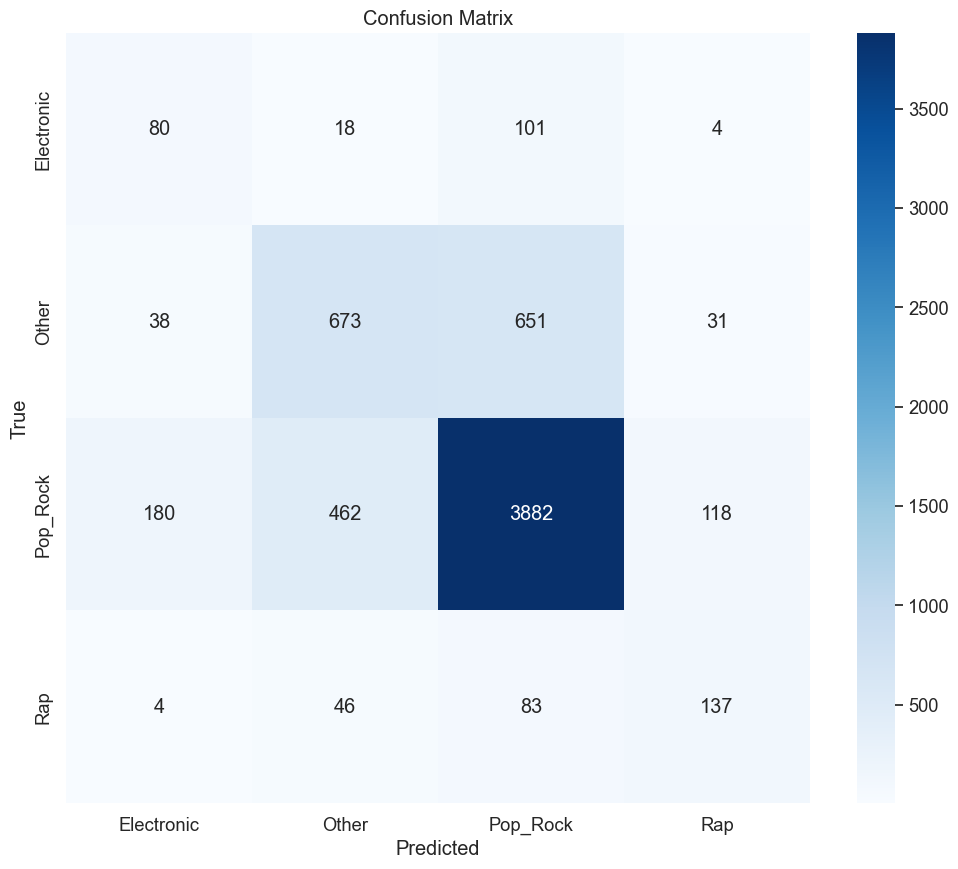

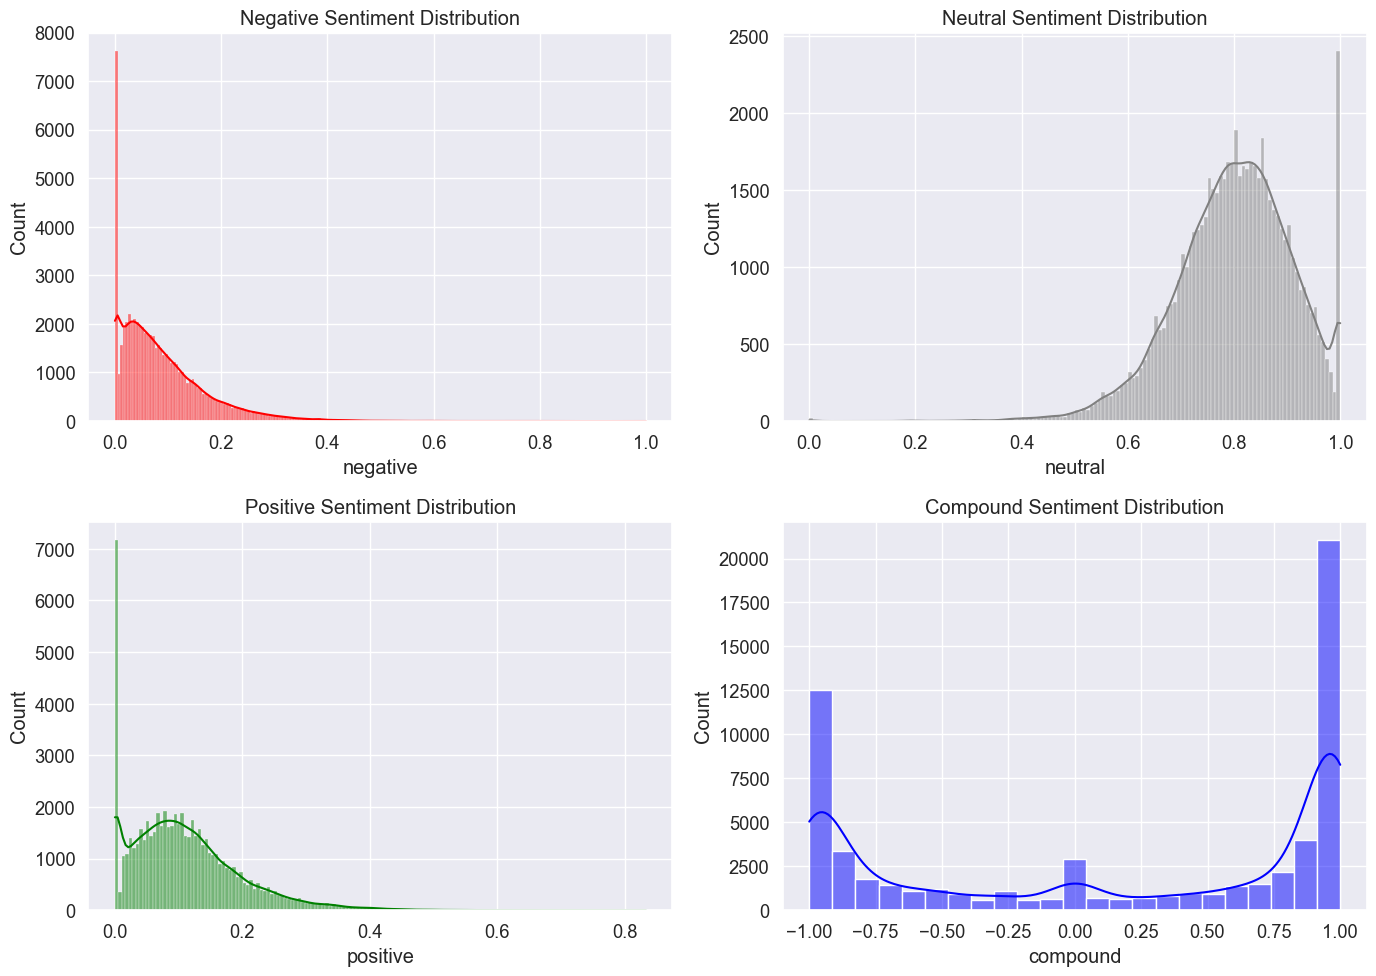

In [7]:
# Initialize with a limited sample size
analyzer = LyricsAnalyzer(
    matches_file='mxm_779k_matches.txt', 
    train_file='mxm_dataset_train.txt',
    sample_size=50000  # uncomment when run locally
)

# Run the analysis
#results = analyzer.run_full_analysis(max_test_samples=None)
results = analyzer.run_full_analysis()

Plotting sentiment distribution for 32141 songs in Pop_Rock genre


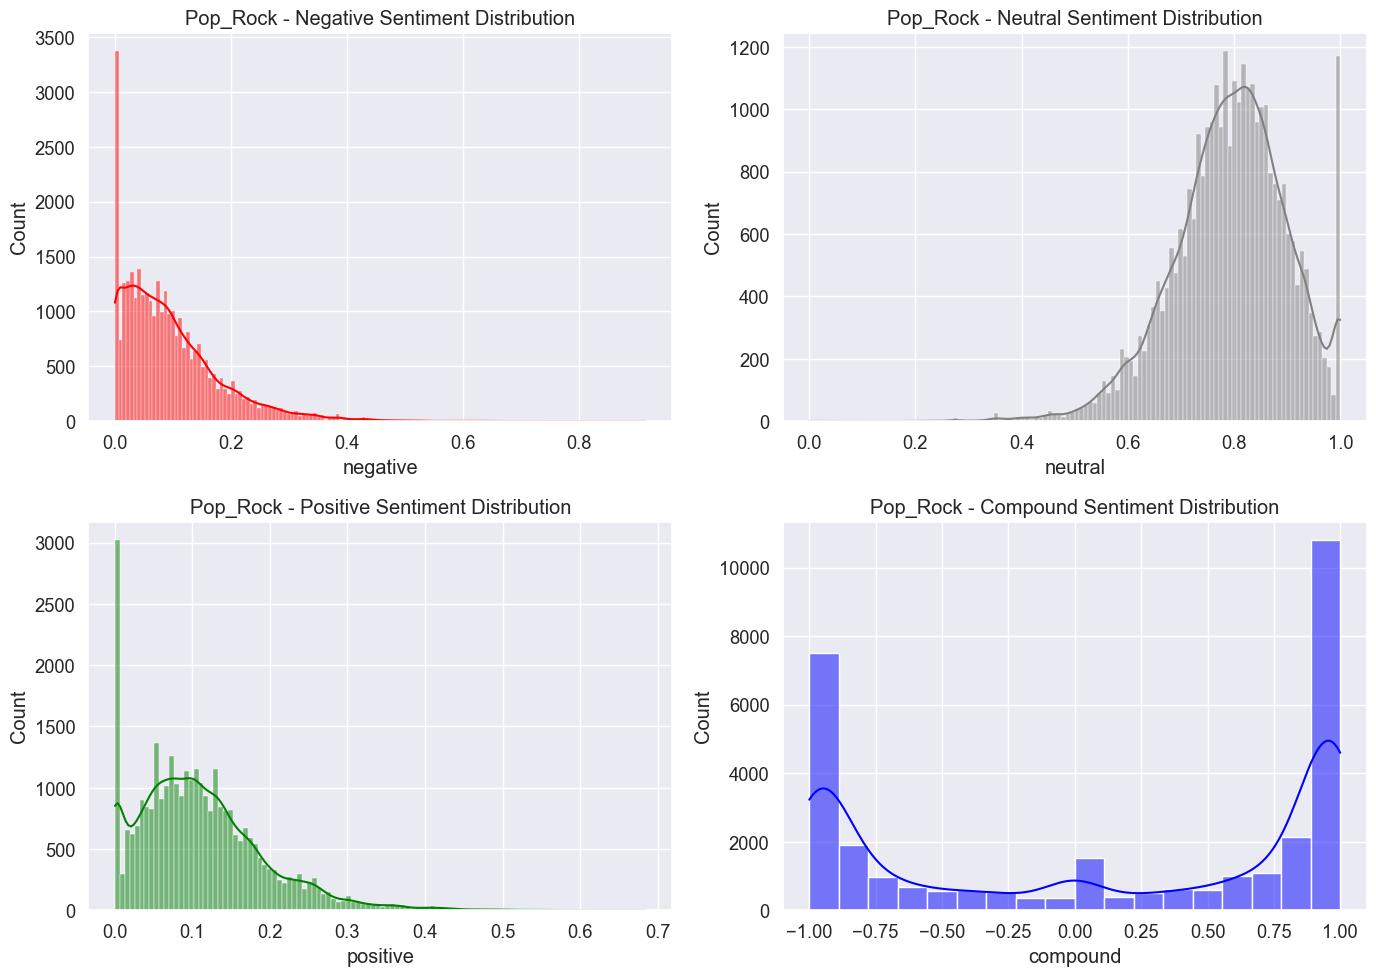

Plotting sentiment distribution for 2296 songs in Rap genre


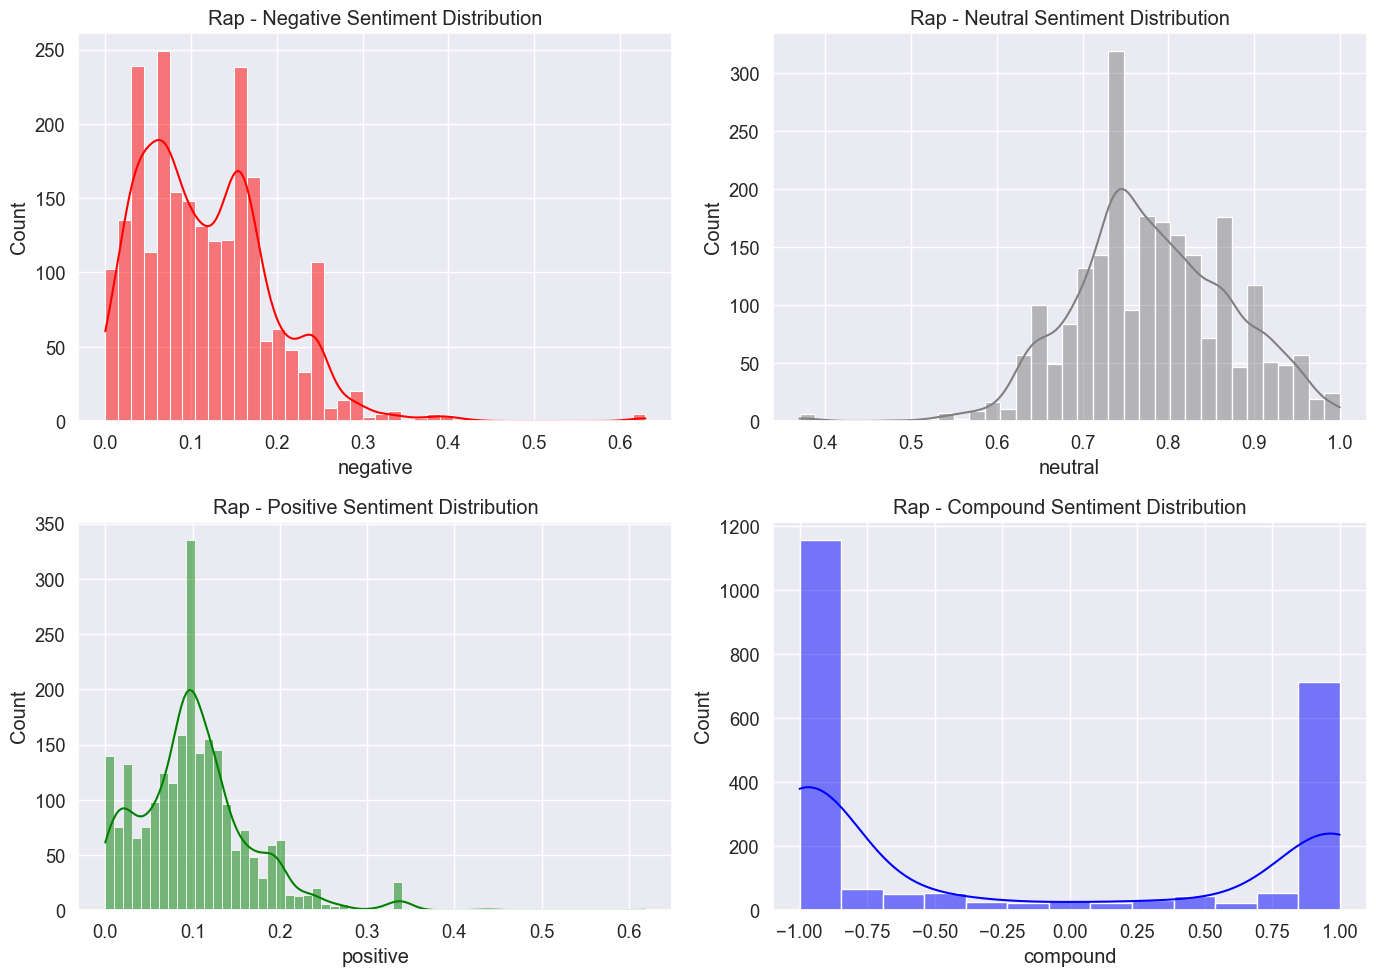

Plotting sentiment distribution for 2259 songs in Electronic genre


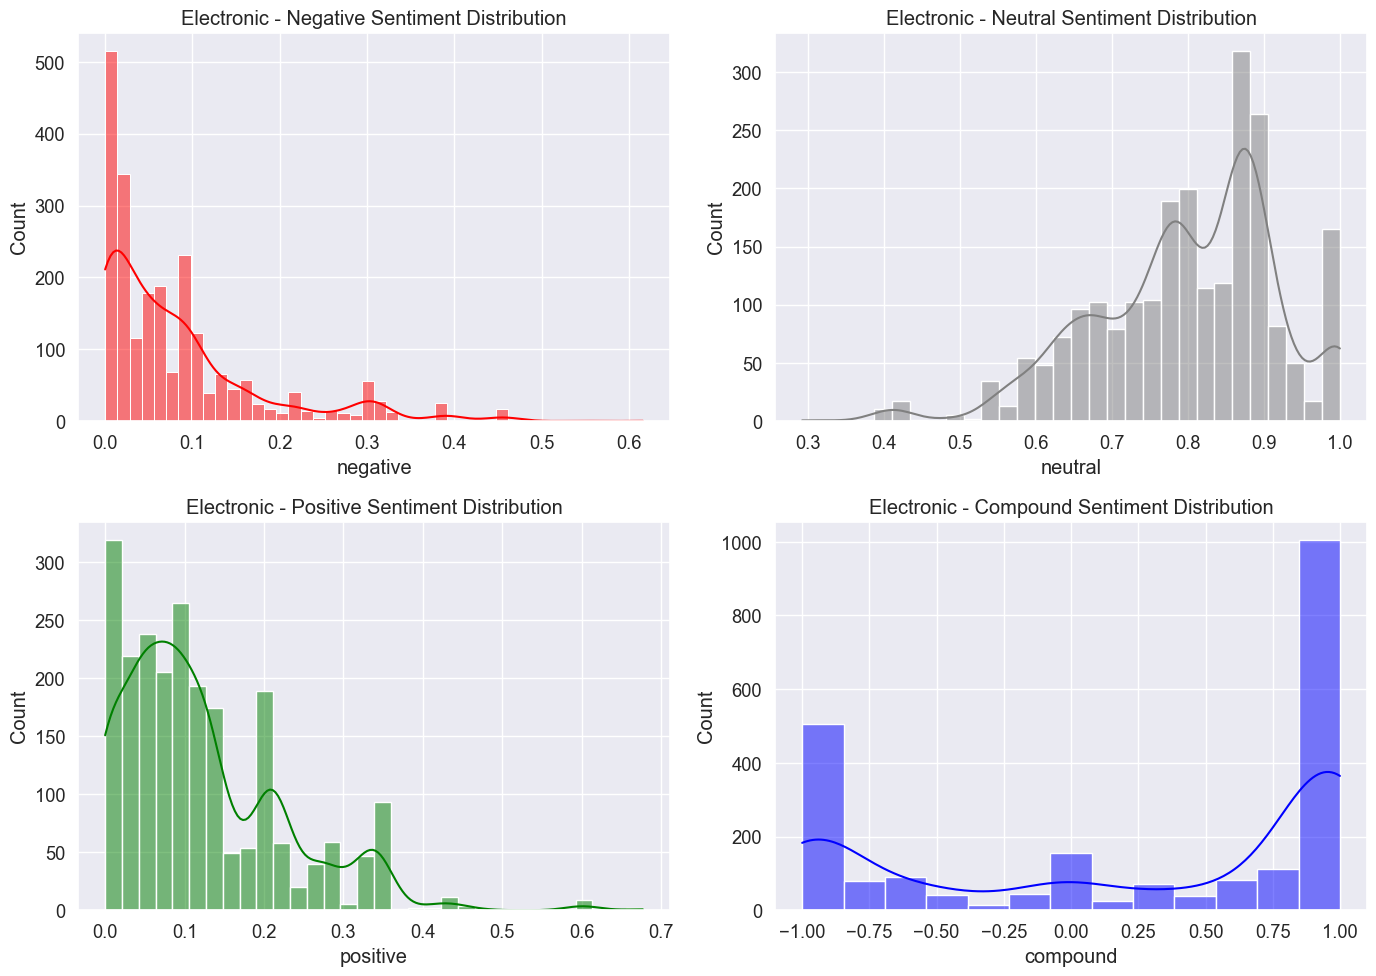

Plotting sentiment distribution for 11979 songs in Other genre


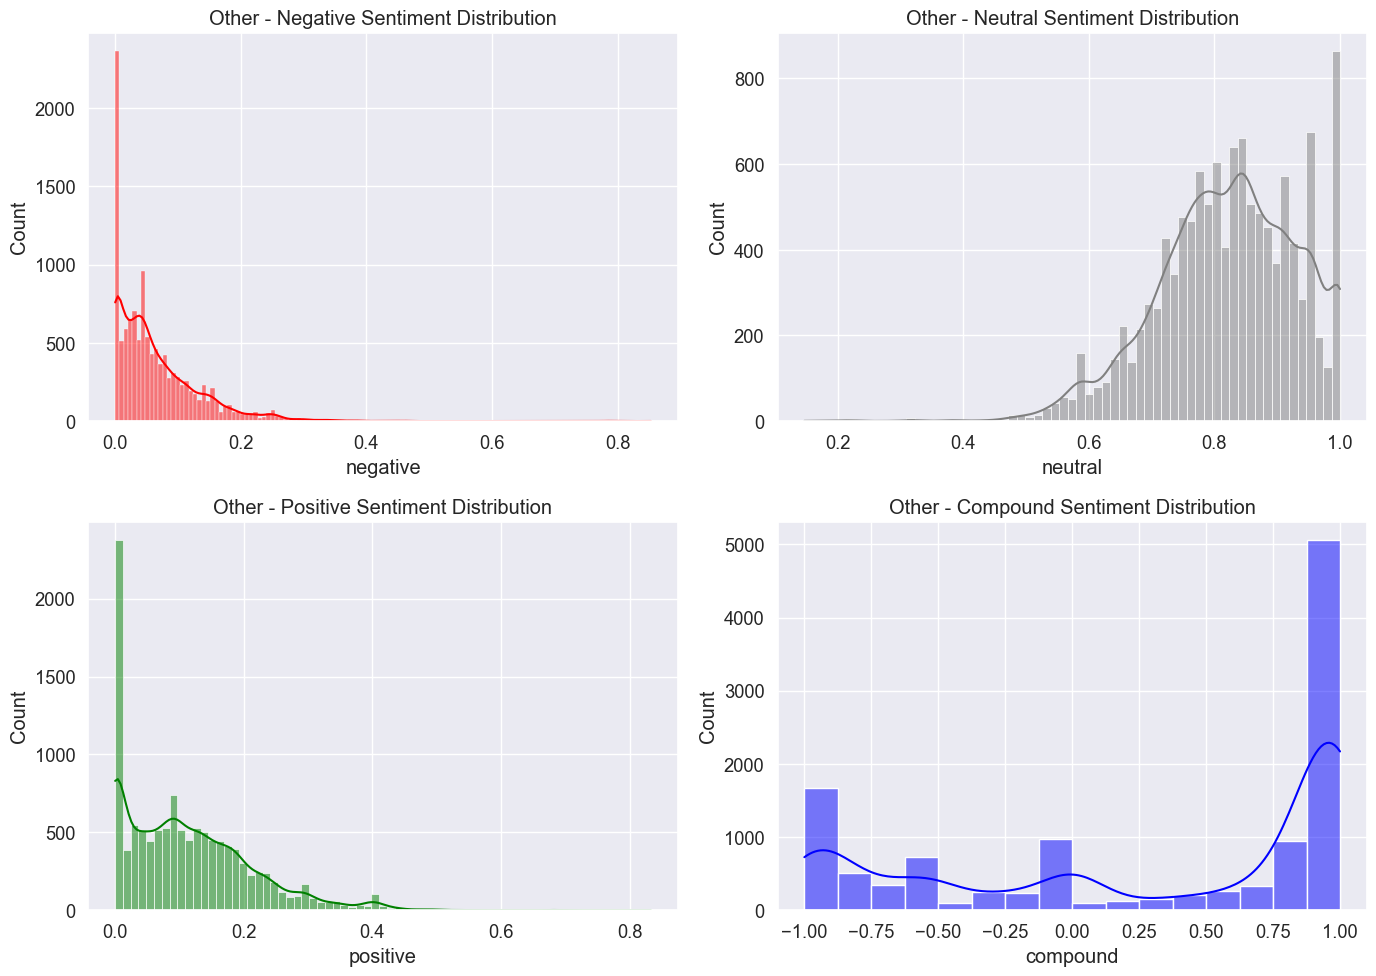

In [8]:
# Target genres
target_genres = ['Pop_Rock', 'Rap', 'Electronic', 'Other']
# Get the data from your results
merged_data = results['merged_data_with_genre']
sentiment_df = results['sentiment']

# Plot sentiment distribution for each genre
for genre in target_genres:
    fig, axs = analyzer.plot_genre_sentiment_distribution(genre, sentiment_df, merged_data)
    if fig:
        plt.figure(fig.number)
        plt.show()

Merged data contains 62985 songs.
Analyzing 11 songs in the ABBA genre
Analyzing 21 songs in the Nirvana genre
Analyzing 15 songs in the Taylor Swift genre
Analyzing 32 songs in the Michael Jackson genre
Analyzing 13 songs in the Eminem genre
Analyzing 39 songs in the Bob Dylan genre
Analyzing 15 songs in the Joy Division genre
Analyzing 18 songs in the Radiohead genre
Analyzing 13 songs in the The Smiths genre
Analyzing 6 songs in the Lady Gaga genre
Analyzing 17 songs in the Linkin Park genre
Analyzing 15 songs in the Seal genre
Analyzing 28 songs in the Frank Sinatra genre


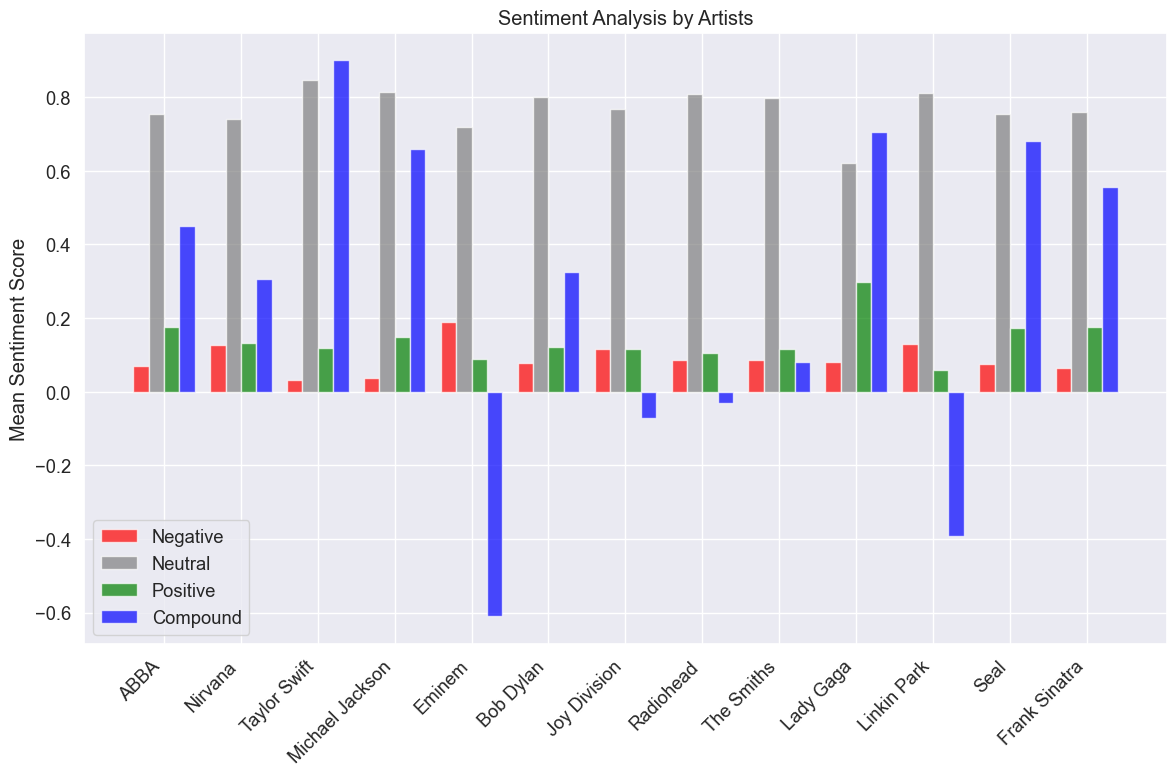

In [9]:
# Example of comparing genres
genre_mapping = {
    'ABBA': ['ABBA'],
    'Nirvana': ['Nirvana'],
    'Taylor Swift': ['Taylor Swift'],
    'Michael Jackson': ['Michael Jackson'],
    'Eminem': ['Eminem'],
    'Bob Dylan': ['Bob Dylan'],
    'Joy Division': ['Joy Division'],
    'Radiohead': ['Radiohead'],
    'The Smiths': ['The Smiths'],
    'Lady Gaga': ['Lady Gaga'],
    'Linkin Park': ['Linkin Park'],
    'Seal': ['Seal'],
    'Frank Sinatra': ['Frank Sinatra']
}

genre_stats = analyzer.compare_genres(genre_mapping)
analyzer.plot_sentiment_by_genre(genre_stats).show()

In [10]:
results['timers']

{'merge_data': [10.42366210000182],
 'sentiment': [134.212998899995],
 'training': [546.7731933999967]}

In [11]:
results['merged_data'].describe(include='all')

,track_id,mxm_track_id,word_counts,msd_track_id,msd_artist_name,msd_title,mxm_artist_name,mxm_title,genre
count,62985,62985,62985,62985,62985,62985,62985,62985,32539
unique,50000,50000,49712,62985,13454,50417,11344,44308,21
top,TRDXZLM128F9330081,4814185,"{'a': 2, 'me': 1, 'on': 1, 'de': 3, 'la': 1, '...",TRZZZQO128E078864C,Cat Stevens,Intro,Frank Sinatra,Intro,Pop_Rock
freq,20,20,20,1,45,79,87,61,23207


In [12]:
results['merged_data_with_genre'].describe(include='all')

,track_id,mxm_track_id,word_counts,msd_track_id,msd_artist_name,msd_title,mxm_artist_name,mxm_title,genre,original_genre
count,32539,32539,32539,32539,32539,32539,32539,32539,32539,32539
unique,27699,27699,27611,32539,8008,27785,7436,25343,4,21
top,TRIGOZN12903CD8257,6729218,"{'a': 5, 'me': 2, 'all': 1, 'no': 2, 'que': 9,...",TRZZZQO128E078864C,Venom,Intro,Venom,Intro,Pop_Rock,Pop_Rock
freq,20,20,20,1,32,40,32,39,23207,23207


In [13]:
results['sentiment'].describe(include='all')

,track_id,artist,title,negative,neutral,positive,compound
count,62985,62985,62985,62985.000000,62985.000000,62985.000000,62985.000000
unique,50000,13454,50417,NaN,NaN,NaN,NaN
top,TRDXZLM128F9330081,Cat Stevens,Intro,NaN,NaN,NaN,NaN
freq,20,45,79,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.088763,0.801004,0.109962,0.148166
std,NaN,NaN,NaN,0.082882,0.109828,0.087528,0.818728
min,NaN,NaN,NaN,0.000000,0.000000,0.000000,-1.000000
25%,NaN,NaN,NaN,0.028000,0.734000,0.046000,-0.831600
50%,NaN,NaN,NaN,0.069000,0.807000,0.097000,0.440400
75%,NaN,NaN,NaN,0.127000,0.877000,0.154000,0.962800


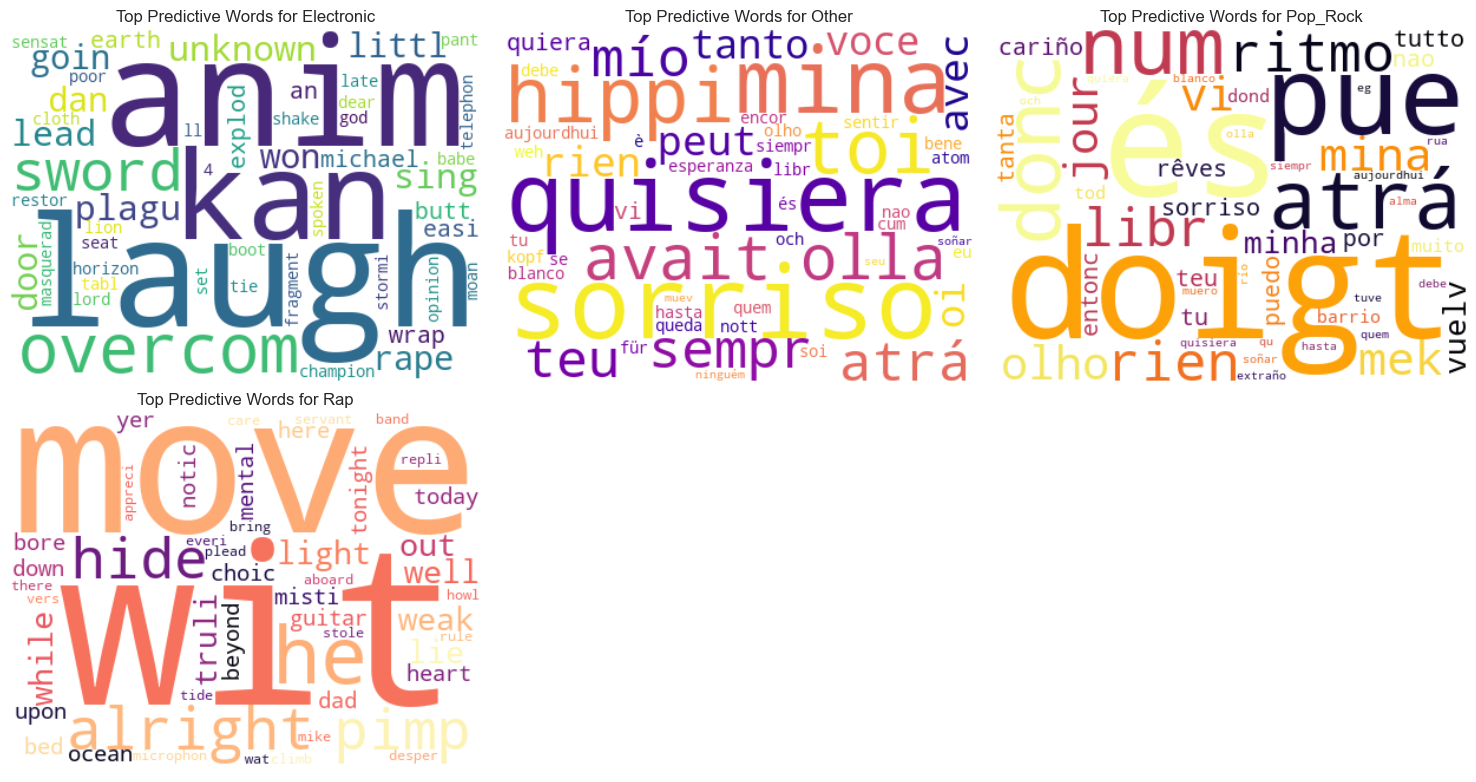

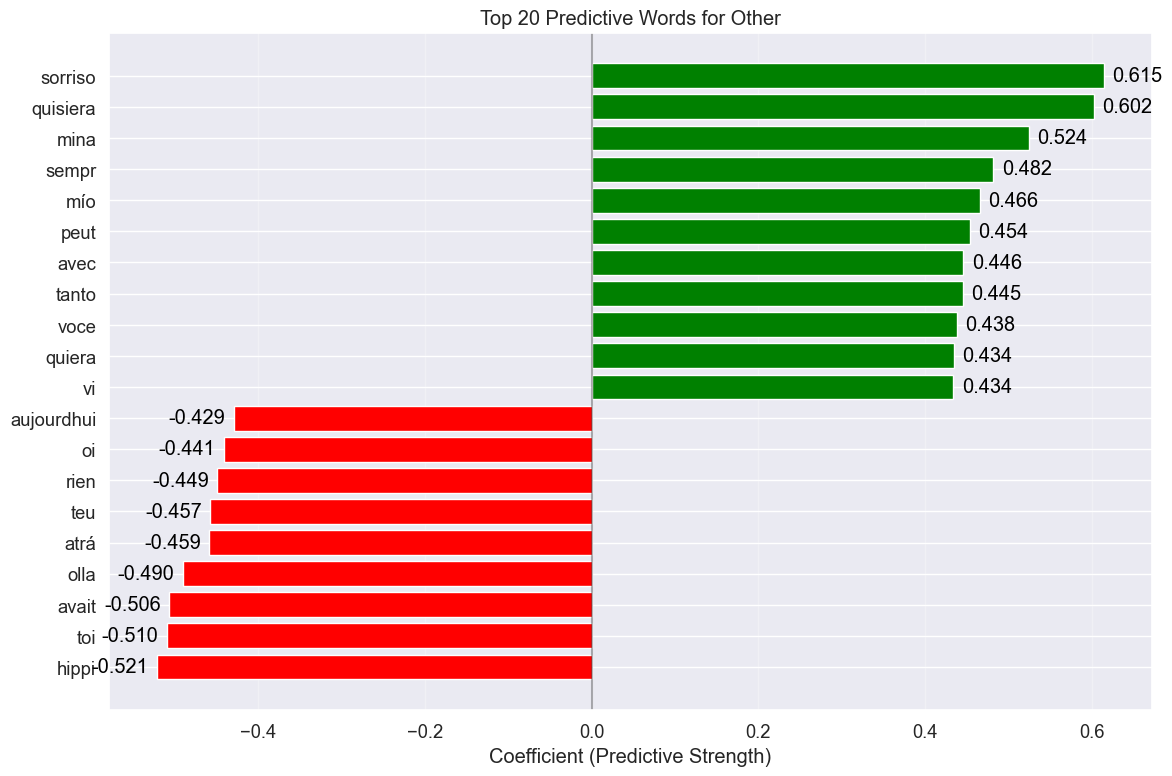

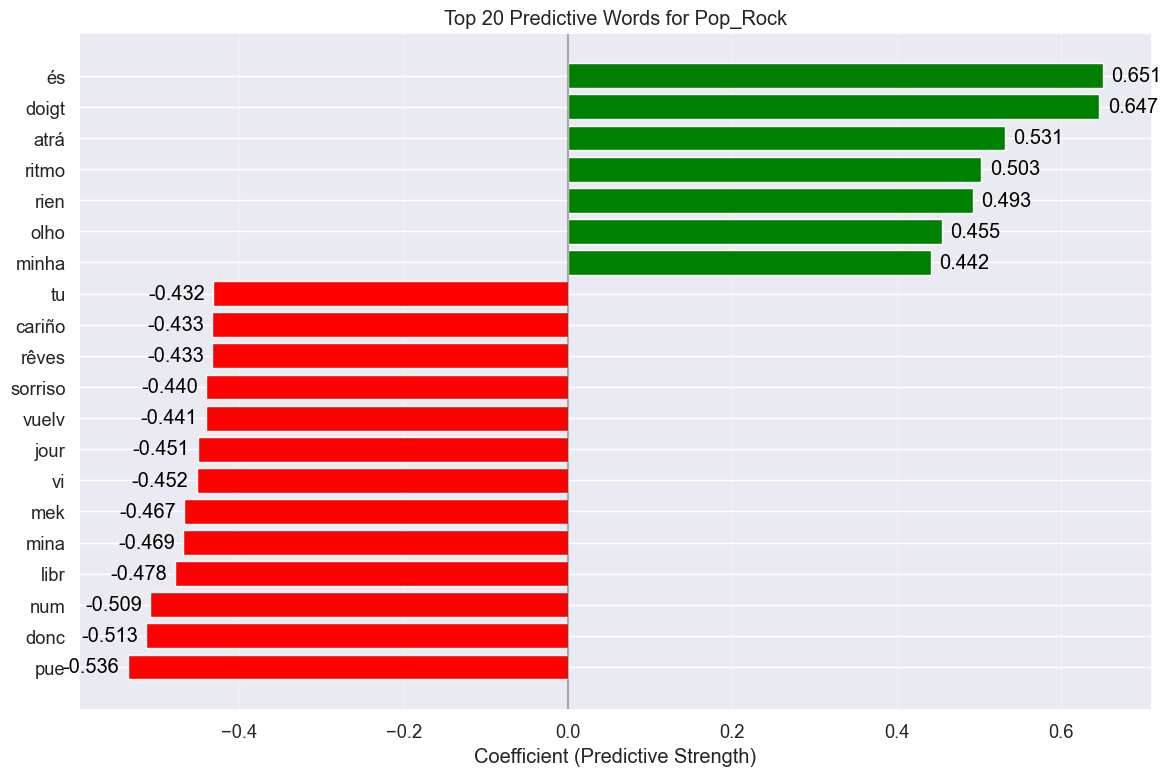

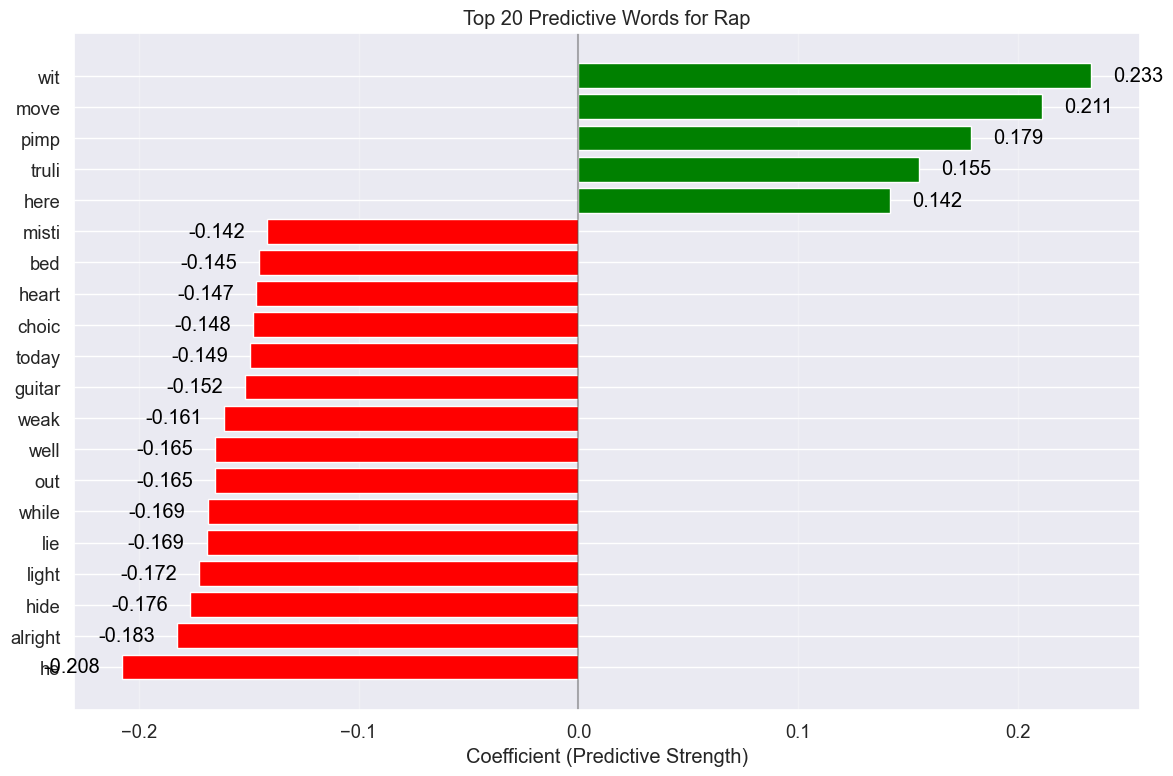

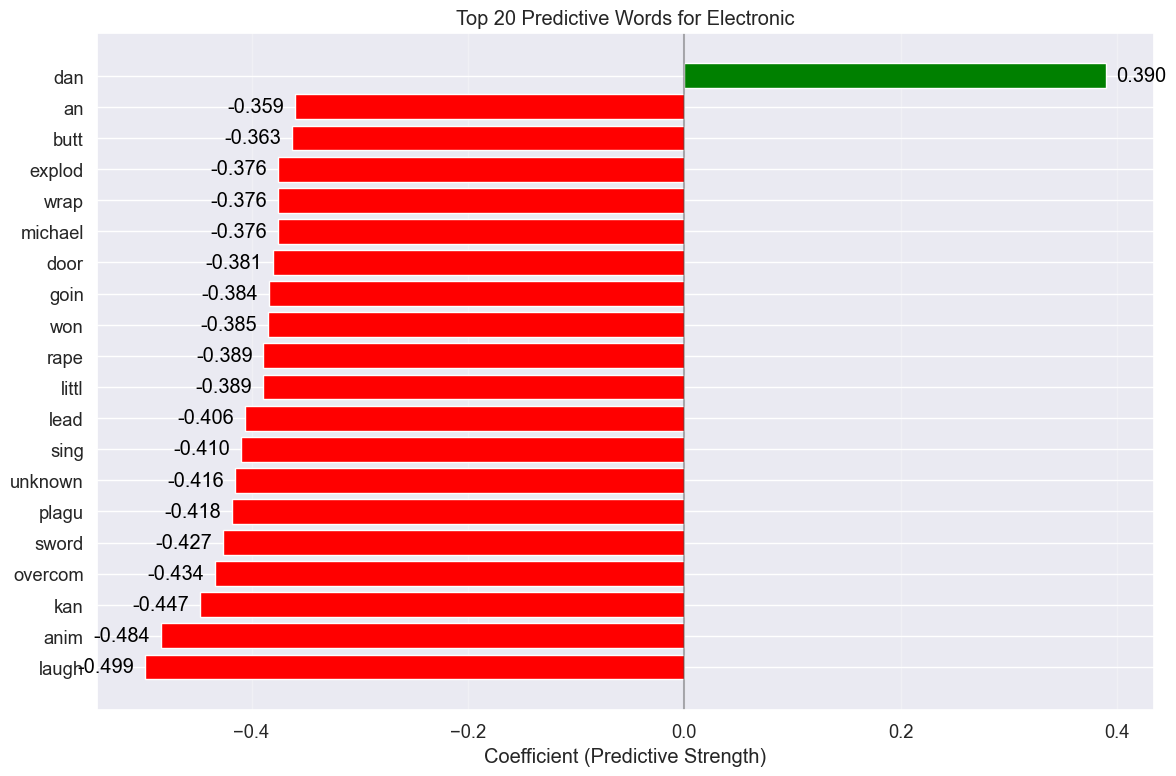

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

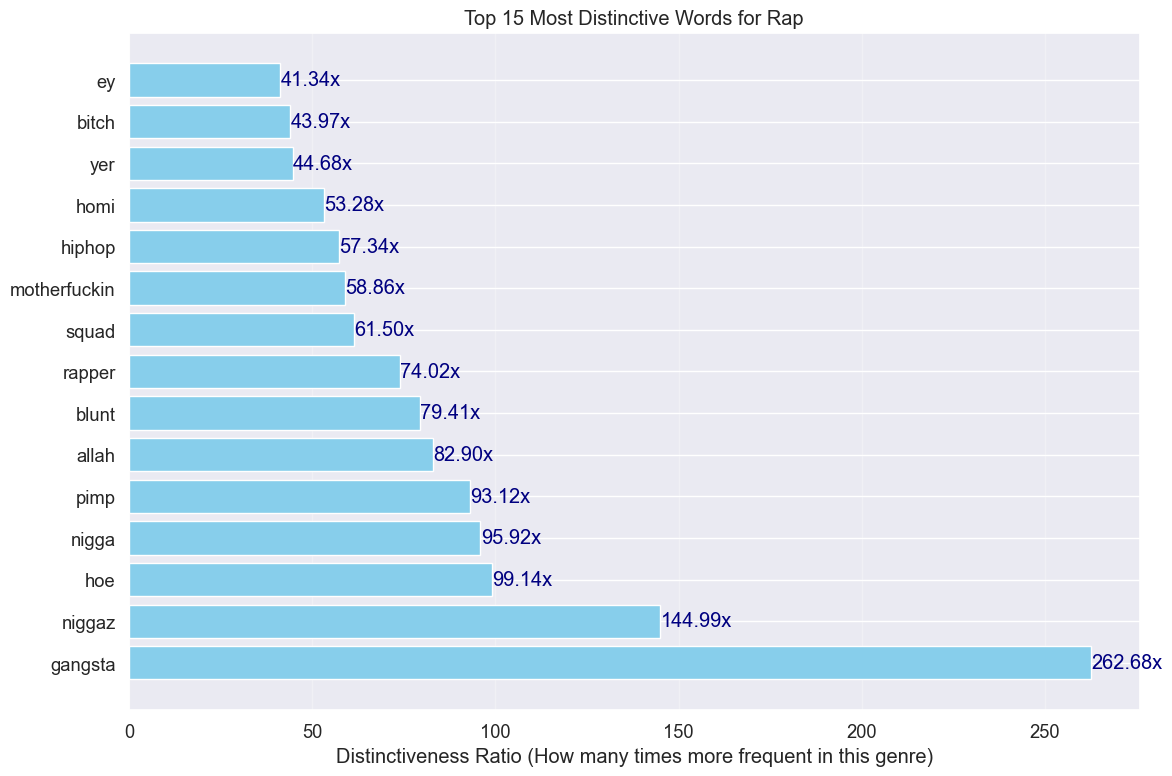

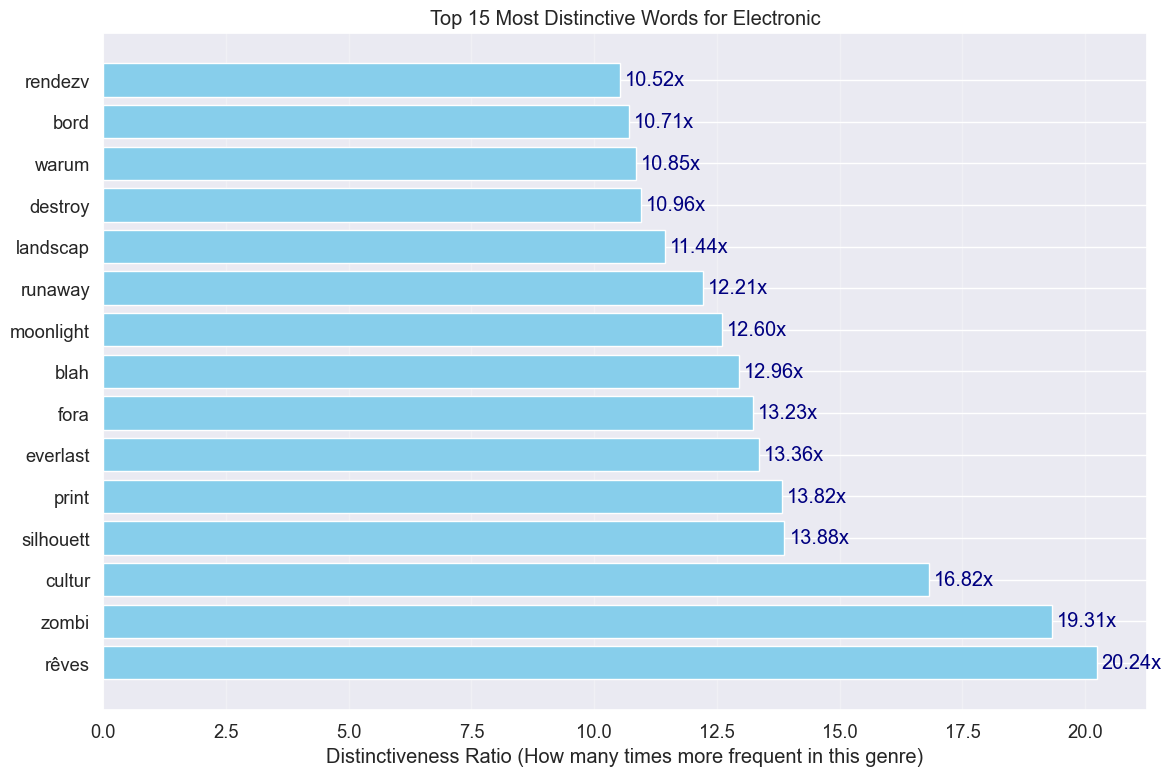

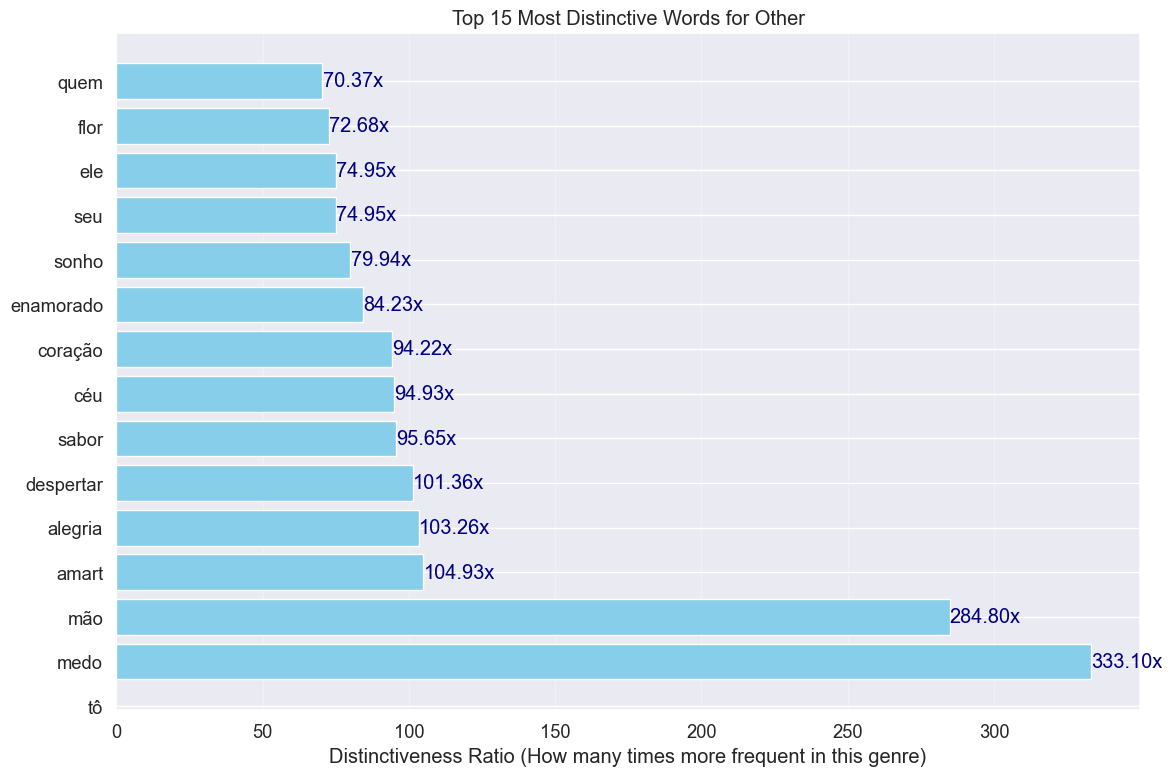

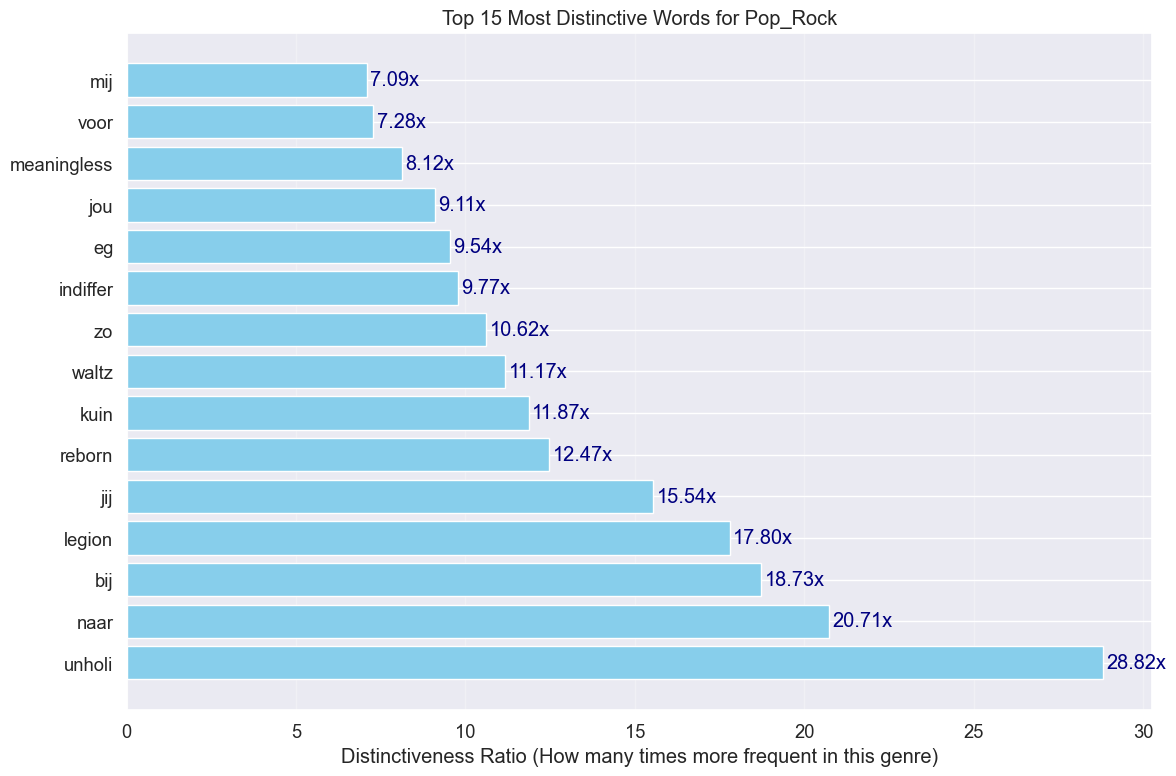

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

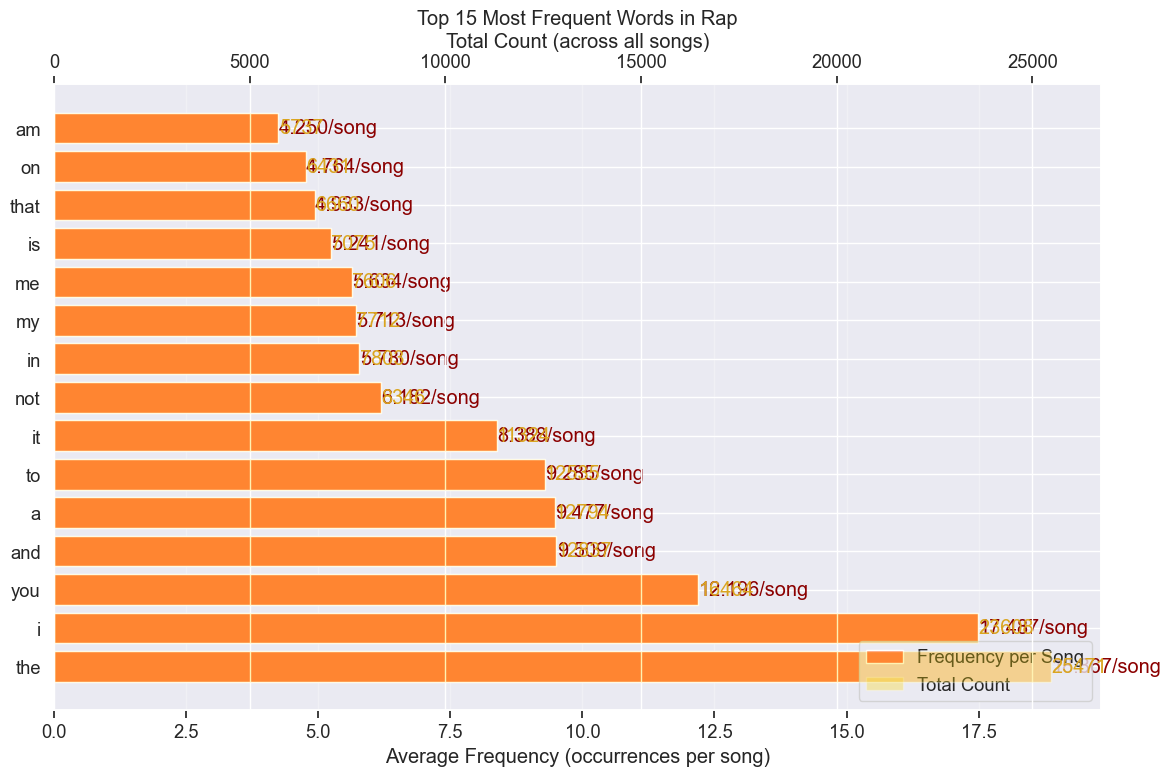

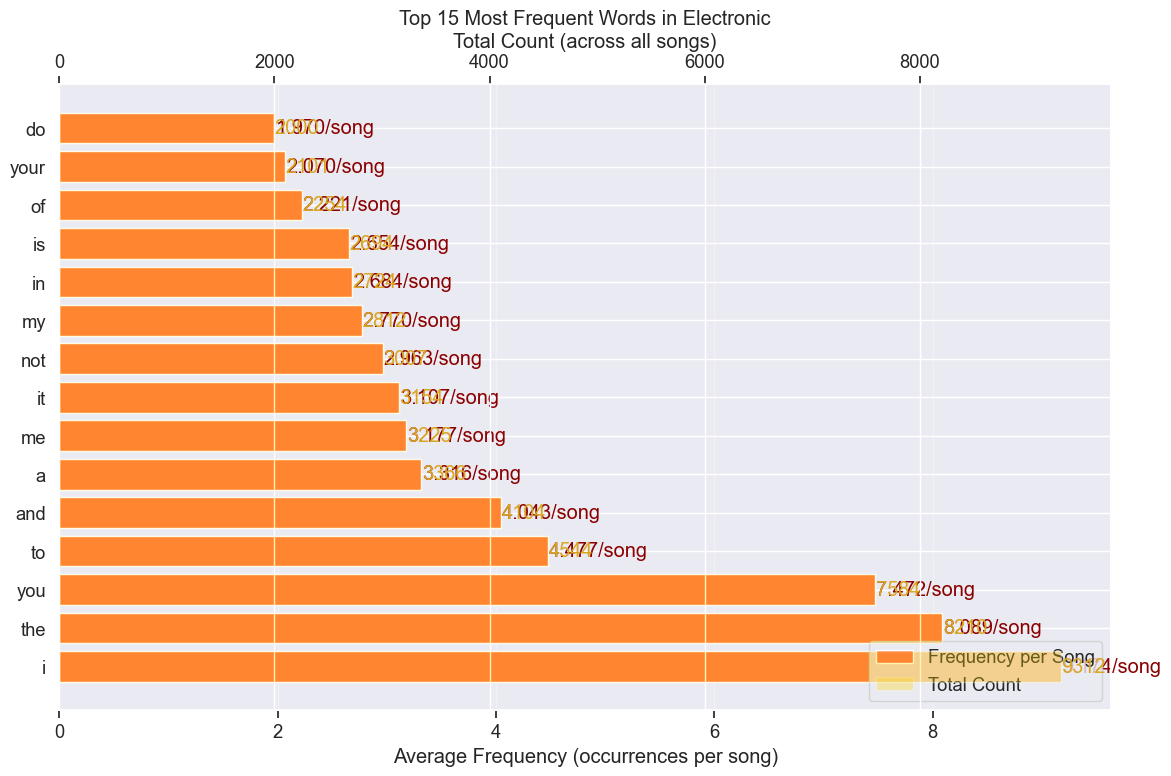

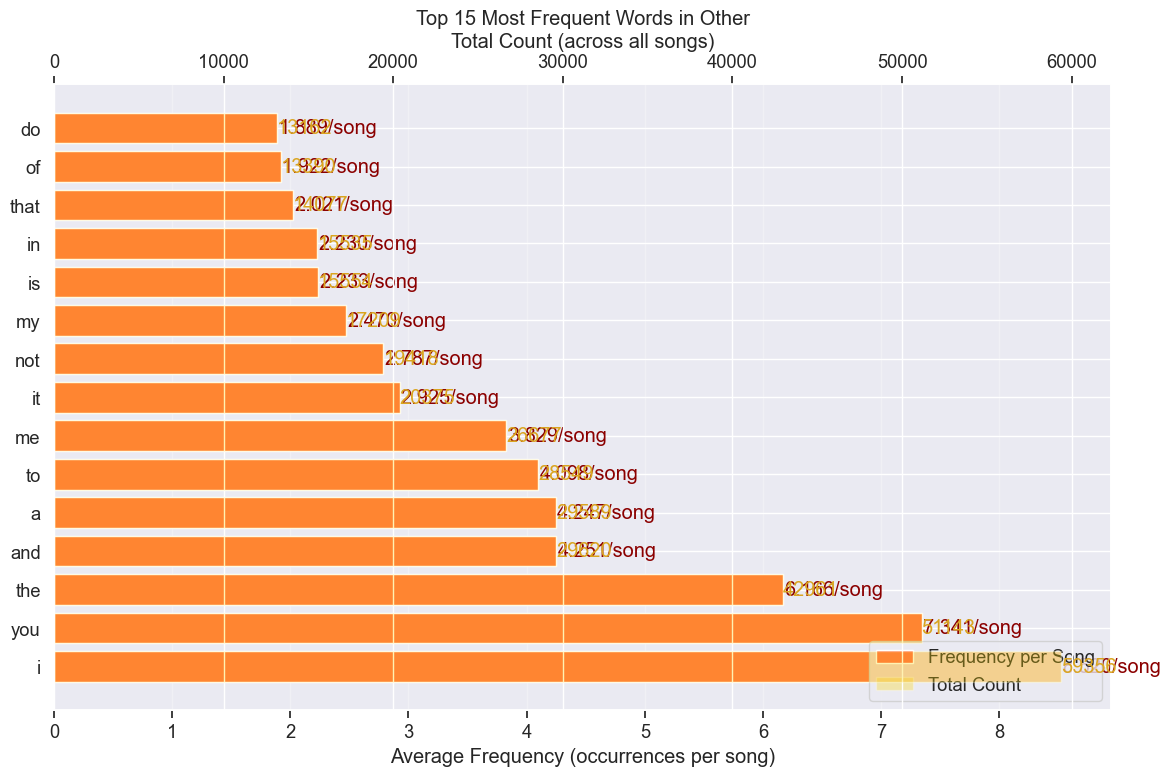

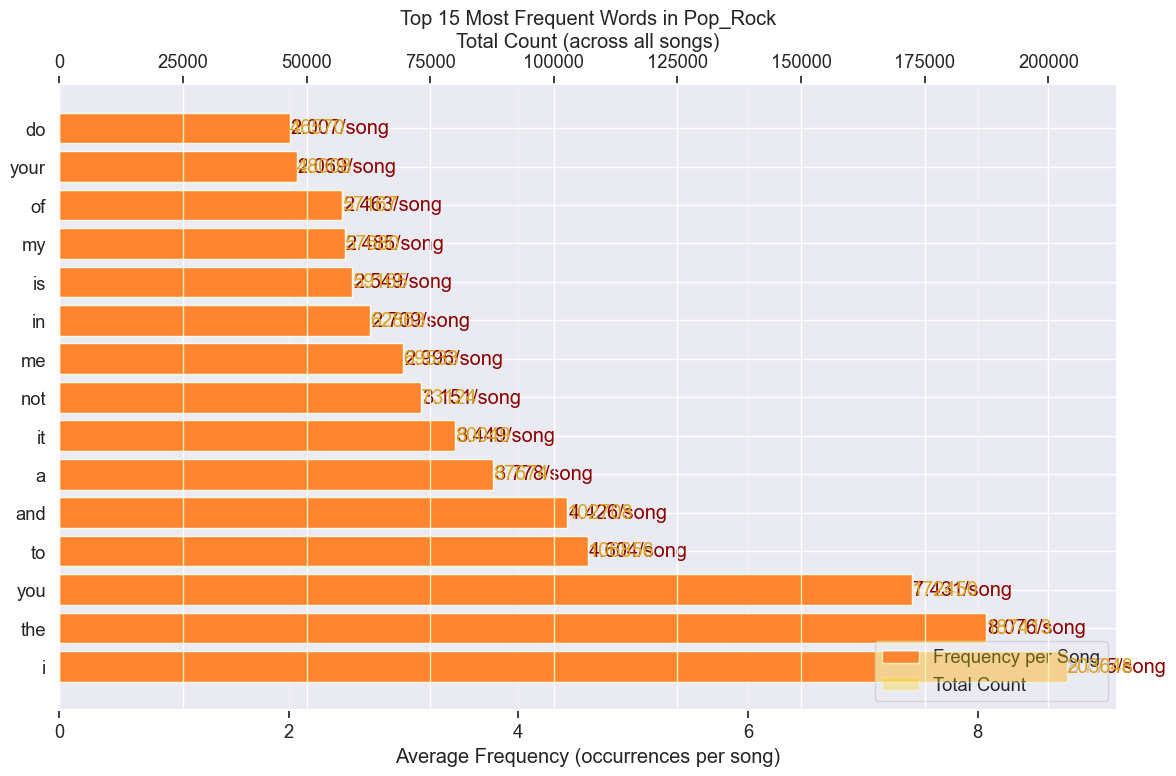

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Top 10 Most Frequent Words Overall:
     word  total_count
3306    i       295924
2637  the       264055
2364  you       247641
2530   to       152484
3340  and       149269
1699    a       133423
4215   it       114902
1408   me       107041
2378  not       103895
1119   in        88925

Top 10 Most Distinctive Words for Pop_Rock:
          word  Pop_Rock_distinctiveness  Pop_Rock_freq
4419    unholi                 28.820270       0.004137
4253      naar                 20.714569       0.002973
3720       bij                 18.733175       0.004481
1073    legion                 17.800664       0.004395
4018       jij                 15.535927       0.002973
3337    reborn                 12.470875       0.004869
3308      kuin                 11.867109       0.002930
4688     waltz                 11.167855       0.002672
2349        zo                 10.617963       0.004654
2102  indiffer                  9.772913       0.002413

Top 10 Most Distinctive Words for Rap:
         

In [14]:
# Get data and model from results
merged_data = results['merged_data_with_genre']
vectorizer = results['vectorizer']
model = results['genre_model']
target_genres = ['Pop_Rock', 'Rap', 'Electronic', 'Other']

# Identify predictive words for each genre
predictive_words = analyzer.identify_genre_predictive_words(
    merged_data=merged_data,
    vectorizer=vectorizer,
    model=model,
    target_genres=target_genres,
    top_n=100
)

# Create word clouds for each genre's predictive words
wordcloud_fig = analyzer.plot_genre_predictive_wordclouds(predictive_words)
plt.figure(wordcloud_fig.number)
#plt.suptitle('Most Predictive Words by Genre', fontsize=16, y=0.98)
plt.show()

# Create bar charts for each genre's top predictive words
predictive_bar_figs = analyzer.compare_genre_predictive_words(
    predictive_words, top_n=20
)
for fig in predictive_bar_figs:
    plt.figure(fig.number)
    plt.tight_layout()
    plt.show()

# Analyze word usage patterns across genres
word_usage_df = analyzer.analyze_word_usage_by_genre(
    merged_data=merged_data,
    target_genres=target_genres,
    min_word_count=50
)


# Plot the most distinctive words for each genre
distinctive_word_figs = analyzer.plot_genre_word_distinctiveness(
    word_usage_df=word_usage_df,
    top_n=15
)
for fig in distinctive_word_figs:
    plt.figure(fig.number)
    plt.tight_layout()
    plt.show()

# Plot the most frequent words for each genre
frequency_word_figs = analyzer.plot_genre_word_frequency(
    word_usage_df=word_usage_df,
    top_n=15
)
for fig in frequency_word_figs:
    plt.figure(fig.number)
    plt.tight_layout()
    plt.show()

# Print some interesting statistics
print("\nTop 10 Most Frequent Words Overall:")
print(word_usage_df[['word', 'total_count']].head(10))

for genre in target_genres:
    print(f"\nTop 10 Most Distinctive Words for {genre}:")
    genre_words = word_usage_df.sort_values(f'{genre}_distinctiveness', ascending=False)
    print(genre_words[['word', f'{genre}_distinctiveness', f'{genre}_freq']].head(10))